# Analysis of Belle2 MonteCarlo Data
### Laboratory for Computational Physics - Modul B

__Authors:__

- Valeria Fioroni (University of Padova)
- Matteo Guida (University of Padova)
- Philipp Zehetner (University of Padova, Ludwig Maximilian University of Munich)
- [Stack Overflow](https://stackoverflow.com/)

__Supervised by:__

- Professor Marco Zanetti (University of Padova, CERN)
- Professor Stefano Lacaprara (University of Padova, BELLE2)

The goal of this project is to find the branching ratio of 
$B^0 \rightarrow \eta' K_S^0$

with $\eta' \rightarrow \eta \; \pi^+ \pi^-$, 
$\eta \rightarrow \gamma \gamma$ and 
$K_S^0 \rightarrow \pi^+ \pi^-$
in Monte Carlo simulation (Data Challenge)

To do this, we build a deep neural network (DNN) with Keras/Tensorflow using labelled data, optimize it and finally use it as a classifier on the Data Challenge

In [1]:
import os, sys, pprint
import glob
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import joblib

In [2]:
Testing = True # Uses only a small subset of the data and trains on fewer epochs. 
PCA_ON = False
Local_Philipp = True
Local_Valeria = False
VM = False

if Testing: print("For testing purpose only a small number of events are used")
if Local_Philipp : print("Paths are set to be run on Philipps Computer")
elif VM : print("Paths are set to run on the VM")

For testing purpose only a small number of events are used
Paths are set to be run on Philipps Computer


## 1. Reading and Cleaning Data

In this chapter we
- read relevant information from root files into pandas data frames
- clean our data sets by removing wrongly reconstructed signal and allowing only one true signal candidate per event
- apply a $5\sigma$ cut on the mass of the reconstructed $B^0$ on all candidates

In [3]:
# Define branches that we need for our analysis
Masses = ['B0_M', 'B0_ErrM', 'B0_SigM', 'B0_K_S0_M', 'B0_K_S0_ErrM', 'B0_K_S0_SigM', 'B0_etap_M', 'B0_etap_ErrM', 
          'B0_etap_SigM', 'B0_etap_eta_M', 'B0_etap_eta_ErrM', 'B0_etap_eta_SigM']
Kinetics_CMS = ['B0_Pcms', 'B0_etap_Pcms', 'B0_etap_eta_Pcms', 'B0_etap_eta_gamma0_Pcms', 'B0_etap_eta_gamma1_Pcms',
                'B0_etap_pi0_Pcms', 'B0_etap_pi1_Pcms', 'B0_K_S0_Pcms']
Other_Kinetics = ['B0_deltae', 'B0_mbc']
DecayAngles = ['B0_decayAngle__bo0__bc', 'B0_decayAngle__bo1__bc', 'B0_etap_decayAngle__bo0__bc',
               'B0_etap_decayAngle__bo1__bc', 'B0_etap_decayAngle__bo2__bc']
Positions = ['B0_X', 'B0_ErrX', 'B0_Y', 'B0_ErrY', 'B0_Z', 'B0_ErrZ', 'B0_Rho',  
             'B0_etap_X', 'B0_etap_ErrX', 'B0_etap_Y', 'B0_etap_ErrY', 
             'B0_etap_Z', 'B0_etap_ErrZ', 'B0_etap_Rho',
             'B0_etap_eta_X', 'B0_etap_eta_ErrX', 'B0_etap_eta_Y',
             'B0_etap_eta_ErrY', 'B0_etap_eta_Z', 'B0_etap_eta_ErrZ', 'B0_etap_eta_Rho',
             'B0_etap_pi0_X', 'B0_etap_pi0_ErrX', 'B0_etap_pi0_Y', 'B0_etap_pi0_ErrY', 
             'B0_etap_pi0_Z', 'B0_etap_pi0_ErrZ', 'B0_etap_pi0_Rho', 
             'B0_etap_pi1_X', 'B0_etap_pi1_ErrX', 'B0_etap_pi1_Y', 'B0_etap_pi1_ErrY', 
             'B0_etap_pi1_Z', 'B0_etap_pi1_ErrZ', 'B0_etap_pi1_Rho', 
             'B0_K_S0_X', 'B0_K_S0_ErrX', 'B0_K_S0_Y', 'B0_K_S0_ErrY', 'B0_K_S0_Z',
             'B0_K_S0_ErrZ', 'B0_K_S0_Rho', 
             'B0_cosAngleBetweenMomentumAndVertexVector', 'B0_distance', 'B0_significanceOfDistance',
             'B0_dr', 'B0_etap_pi0_dr', 'B0_etap_pi1_dr', 'B0_K_S0_dr']
Vertex_Training = ['B0_VtxPvalue', 'B0_etap_VtxPvalue', 'B0_etap_eta_VtxPvalue', 'B0_etap_pi0_VtxPvalue',
                   'B0_etap_pi1_VtxPvalue', 'B0_K_S0_VtxPvalue', ]
Continuum_Suppression_Training = ['B0_TrCSMVA']

Training = Kinetics_CMS + Masses + Other_Kinetics + Continuum_Suppression_Training + Positions + DecayAngles + Vertex_Training
Important = Training + ['B0_isSignal', 'evt_no']

In [4]:
def memory(df):
    print(str((round(df.memory_usage(deep=True).sum() / 1024 ** 2, 2))),"Mb")

In [5]:
from root_pandas import read_root

if Local_Philipp and not VM : 
    path = '/home/philipp/Desktop/Project/DATA/'
    SFiles = glob.glob(os.path.join(path, 'Signal/*.root'))
    CFiles = glob.glob(os.path.join(path, 'Continuous/*.root'))
    PFiles = glob.glob(os.path.join(path, 'Peaking/*.root'))
    
elif VM and not Local_Philipp : 
    print('Please set path for VM here')
    
elif Local_Valeria:  
    path = '/home/utente/Scrivania/Progetto LCP-B/DataBelle2/'
    SFiles = glob.glob(os.path.join(path, 'Signal/*.root'))
    CFiles = glob.glob(os.path.join(path, 'Background/Continuum/*.root'))
    PFiles = glob.glob(os.path.join(path, 'Background/Peaking/*.root'))
    

Signal = pd.concat((read_root(f, 'B0', columns=Important) for f in SFiles))
Signal = Signal[Signal['B0_isSignal']==1].reset_index(drop=True)
Continuum_bkg = pd.concat((read_root(f, 'B0', columns=Important) for f in CFiles))
Peaking_bkg = pd.concat((read_root(f, 'B0', columns=Important) for f in PFiles))

print ("Memory used by Signal", memory(Signal))
print ("Memory used by Continuum", memory(Continuum_bkg))
print ("Memory used by Peaking", memory(Peaking_bkg))

Welcome to JupyROOT 6.16/00


/home/philipp/anaconda3/envs/Belle/lib/python3.7/site-packages/root_numpy/__init__.py:46: RuntimeWarning: numpy 1.16.4 is currently installed but you installed root_numpy against numpy 1.9.3. Please consider reinstalling root_numpy for this numpy version.
  RuntimeWarning)


71.3 Mb
Memory used by Signal None
77.18 Mb
Memory used by Continuum None
0.49 Mb
Memory used by Peaking None


### $5\sigma$ Cut on Reconstructed $B^0$ Mass

The reconstructed mass of the $B^0$ will differ for various reasons: 

- If an event is correctly reconstructed detector inaccuracies of all measured decay particles will add up. The estimated error for each candidate due to this can be found in the branch *B0_ErrM* and is part of our data frame. 
- If the event however is not correctly reconstructed the $B^0$ mass is not necessarily a meaningful quantity an can be far of the desired [PDG](http://pdg.lbl.gov/) value. 

By applying a generous $5\sigma$ cut we already lose a significant amount of backround

In [6]:
#Masses from PDG
M_B0 = [5.27955, 0.00026]
M_K0 = [0.497611, 0.000013]
M_etap = [0.95778, 0.00006]
M_eta = [0.547862, 0.000017]

#Require the B0 mass to be within 5 sigma from PDG value
Signal = Signal[abs(Signal['B0_M'] - M_B0[0]) < 5 * Signal['B0_ErrM']]
print(Signal.shape)

Continuum_bkg = Continuum_bkg[abs(Continuum_bkg['B0_M'] - M_B0[0]) < 5 * Continuum_bkg['B0_ErrM']]
print(Continuum_bkg.shape)

Peaking_bkg = Peaking_bkg[abs(Peaking_bkg['B0_M'] - M_B0[0]) < 5 * Peaking_bkg['B0_ErrM']]
print(Peaking_bkg.shape)

#Signal: In case of more than 1 candidate per event select the first one occuring
Mask_duplicated = Signal.duplicated(subset='evt_no', keep='first')
Mask_duplicated=np.logical_not(Mask_duplicated)
Signal=Signal[Mask_duplicated]
Signal.reset_index(drop=True, inplace=True)

print(Signal.shape)
print(Signal['evt_no'].nunique())

Signal=Signal[Training]
Continuum_bkg=Continuum_bkg[Training]
Peaking_bkg=Peaking_bkg[Training]

(213579, 85)
(120103, 85)
(933, 85)
(212354, 85)
212354


## 2. Data Preprocessing

In this chapter we
- label our data
- turn the label into one-hot vectors as this format is needed by Keras
- split signal, continuum and peaking separatly into training (50%), valdation (30%) and testing (20%) to assure to have a fair amount of each type in all sets
- combine and shuffle signal, continuum and peaking for training, validation and testing, making sure that the labels are shuffled with the same permutation as the data
- standardize the data (removing mean and scaling the standard deviation to 1)
- perform a Principal Component Analysis (PCA) and use the principal components necessary for 99% of the variance

In [7]:
from random import seed
from random import randint

n_seed=1234
seed(n_seed)

In [8]:
Signal['Type'] = 2
Continuum_bkg['Type'] = 1
Peaking_bkg['Type'] = 0

In [9]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

#SIGNAL: Train, Validation and test split (50%, 30%, 20%)
#Dataset divided into 50% of train data and 50% for validation and test
X = Signal.drop('Type',axis=1)
Y = Signal['Type']
Y = to_categorical(Y, num_classes=3) # Binarize the labels
X_train_S, X_test_val_S, Y_train_S, Y_test_val_S = train_test_split(X, Y, train_size=0.5,random_state=randint(10**6,10**9))
#validation and test set divided into 30% for validation and 20% for test
X = X_test_val_S
Y = Y_test_val_S
X_validation_S, X_test_S, Y_validation_S, Y_test_S = train_test_split(X, Y, train_size=0.6,random_state=randint(10**6,10**9))
del(X_test_val_S)
del(Y_test_val_S)

#CONTINUUM BKG: Train, Validation and test split (50%, 30%, 20%)
#Dataset divided into 50% of train data and 50% for validation and test
X = Continuum_bkg.drop('Type',axis=1)
Y = Continuum_bkg['Type']
Y = to_categorical(Y, num_classes=3) # Binarize the labels
X_train_C, X_test_val_C, Y_train_C, Y_test_val_C = train_test_split(X, Y, train_size=0.5,random_state=randint(10**6,10**9))
#validation and test set divided into 30% for validation and 20% for test
X = X_test_val_C
Y = Y_test_val_C
X_validation_C, X_test_C, Y_validation_C, Y_test_C = train_test_split(X, Y, train_size=0.6,random_state=randint(10**6,10**9))
del(X_test_val_C)
del(Y_test_val_C)

#PEAKING BKG: Train, Validation and test split (50%, 30%, 20%)
#Dataset divided into 50% of train data and 50% for validation and test
X = Peaking_bkg.drop('Type',axis=1)
Y = Peaking_bkg['Type']
Y = to_categorical(Y, num_classes=3) # Binarize the labels
X_train_P, X_test_val_P, Y_train_P, Y_test_val_P = train_test_split(X, Y, train_size=0.5,random_state=randint(10**6,10**9))
#validation and test set divided into 30% for validation and 20% for test
X = X_test_val_P
Y = Y_test_val_P
X_validation_P, X_test_P, Y_validation_P, Y_test_P = train_test_split(X, Y, train_size=0.6,random_state=randint(10**6,10**9))
del(X_test_val_P)
del(Y_test_val_P)

del(Signal)
del(Peaking_bkg)
del(Continuum_bkg)

Using TensorFlow backend.


In [10]:
#Define Training, Validation and Test datasets
X_Train=np.concatenate((X_train_S, X_train_C, X_train_P), axis=0)
X_Validation=np.concatenate((X_validation_S, X_validation_C, X_validation_P), axis=0)
X_Test=np.concatenate((X_test_S, X_test_C, X_test_P), axis=0)

Y_Train=np.concatenate((Y_train_S, Y_train_C, Y_train_P), axis=0)
Y_Validation=np.concatenate((Y_validation_S, Y_validation_C, Y_validation_P), axis=0)
Y_Test=np.concatenate((Y_test_S, Y_test_C, Y_test_P), axis=0)

print(X_Train.shape)
print(X_Validation.shape)
print(X_Test.shape)

print(X_Train.nbytes/(1024 ** 2), "Mb")
print(X_Validation.nbytes/(1024 ** 2), "Mb")
print(X_Test.nbytes/(1024 ** 2), "Mb")
n_classes = Y_Train.shape[1]


#shuffle the dataset
permutation = np.random.permutation(X_Train.shape[0])
X_Train = X_Train[permutation]
Y_Train = Y_Train[permutation]

permutation = np.random.permutation(X_Validation.shape[0])
X_Validation = X_Validation[permutation]
Y_Validation = Y_Validation[permutation]

permutation = np.random.permutation(X_Test.shape[0])
X_Test = X_Test[permutation]
Y_Test = Y_Test[permutation]

(166694, 83)
(100017, 83)
(66679, 83)
52.77863311767578 Mb
31.667369842529297 Mb
21.111896514892578 Mb


In [11]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
X_Train = ss.fit_transform(X_Train)
X_Test = ss.transform(X_Test)
X_Validation = ss.transform(X_Validation)

joblib.dump(ss, 'Scaler.pkl')

['Scaler.pkl']

### PCA
PCA is a method often used to reduce the dimensionality of a data set. Orthogonal transformations are performed on the data set to find the directions with the highest variance. The rotated features (principal components) are sorted in descending variance. 
The assumption made is, that high variance corresponds to more information and little variance can be neglected as noise. 

In our example we require to keep 99% of the total variance and thus can reduce the number of components from 83 to 50

In [12]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

if PCA_ON : 
    pca = PCA(n_components=len(Training))
    pcTrain = pd.DataFrame(data = pca.fit_transform(X_Train))
    pcTest = pd.DataFrame(data = pca.transform(X_Test))
    pcValidation = pd.DataFrame(data = pca.transform(X_Validation))

    T50, T90, T95, T99, = False, False, False, False
    for i in range(len(pca.explained_variance_ratio_)) : 
        if (sum(pca.explained_variance_ratio_[:i+1]) > 0.5 and T50 ==False) : 
            print(str(i+1) + ' variables explain 50% of the variance')
            T50 = True
            n_50 = i + 1 
        if (sum(pca.explained_variance_ratio_[:i+1]) > 0.9 and T90 ==False) : 
            print(str(i+1) + ' variables explain 90% of the variance')
            T90 = True
            n_90 = i + 1
        if (sum(pca.explained_variance_ratio_[:i+1]) > 0.95 and T95 ==False) : 
            print(str(i+1) + ' variables explain 95% of the variance')
            T95 = True
            n_95 = i + 1
        if (sum(pca.explained_variance_ratio_[:i+1]) > 0.99 and T99 ==False) : 
            print(str(i+1) + ' variables explain 99% of the variance')
            T99 = True
            n_99 = i + 1
        
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Explained Variance')
    plt.show()
    joblib.dump(pca, 'PCA.pkl')
    
else : 
    pcTrain = X_Train
    pcTest = X_Test
    pcValidation = X_Validation
    
    
pcTest.shape

(66679, 83)

In [13]:
# For input_dim chose n_50, n_90, n_95 or n_99 depending on how much explained variance we require
if PCA_ON : 
    input_dim = n_99
    pcTrain = pcTrain.iloc[:, 0:input_dim]
    pcTest = pcTest.iloc[:, 0:input_dim]
    pcValidation = pcValidation.iloc[:, 0:input_dim]
    print ("Input Dimension has been reduced to ", n_99)
else : 
    input_dim = 83
    print("Input Dimension has not been reduced")

Input Dimension has not been reduced


## 3. Create the Neural Network 

In [14]:
optimizer = ['SGD', 'Adam']
epochs = [10, 30]
if Testing : epochs = [1, 2]
batch_size = [100, 1000]
if Testing : batch_size = [1000]
architectures = [ [50, 50], [50, 100, 50], [50, 100, 100, 50] ] 
if Testing : architectures = [ [50, 50] ]
activation = ['relu', 'elu']

In [15]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.constraints import maxnorm
from keras.wrappers.scikit_learn import KerasClassifier

def build_DNN(optimizer='adam', activation='relu'):
    model = Sequential()
    model.add(Dropout(0.2, input_shape=(pcTrain.shape[1],)))
    model.add(Dense(layers[0], input_shape=(pcTrain.shape[1],), activation='relu'))
    for i in range(1,len(layers)):
        model.add(Dense(layers[i], activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dense(3, activation='sigmoid'))
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
    return model

def print_results() :
    print("Layers: ", layers)
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params): 
        print("%f (%f) with %r" % (mean, stdev, param))

In [16]:
pcTrain.shape[1]

83

In [17]:
from sklearn.model_selection import GridSearchCV

results = []
grids = []
for architecture in architectures : 
    layers = architecture
    print("Using architecture: ", layers)
    model = KerasClassifier(build_fn=build_DNN, batch_size=10000, epochs=2)
    param_grid = dict(epochs=epochs, batch_size=batch_size,
                      activation=activation, optimizer=optimizer)
    grid = GridSearchCV(estimator=model, param_grid=param_grid,
                        n_jobs=-1, pre_dispatch=8)
    grid_result = grid.fit(pcTrain, Y_Train)
    results.append(grid_result)
    grids.append(grid)
    print_results()

Using architecture:  [50, 50]


/home/philipp/anaconda3/envs/Belle/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
W0719 00:40:17.575083 139758201501504 deprecation_wrapper.py:119] From /home/philipp/anaconda3/envs/Belle/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0719 00:40:17.599732 139758201501504 deprecation_wrapper.py:119] From /home/philipp/anaconda3/envs/Belle/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0719 00:40:17.602752 139758201501504 deprecation_wrapper.py:119] From /home/philipp/anaconda3/envs/Belle/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placehold

Epoch 1/2
166694/166694 [==============================] - 1s 9us/step - loss: 0.0698 - acc: 0.8808
Epoch 2/2
166694/166694 [==============================] - 1s 5us/step - loss: 0.0163 - acc: 0.9698
Layers:  [50, 50]
Best: 0.979903 using {'activation': 'relu', 'batch_size': 1000, 'epochs': 2, 'optimizer': 'SGD'}
0.974330 (0.000772) with {'activation': 'relu', 'batch_size': 1000, 'epochs': 1, 'optimizer': 'SGD'}
0.970311 (0.001339) with {'activation': 'relu', 'batch_size': 1000, 'epochs': 1, 'optimizer': 'Adam'}
0.979903 (0.001129) with {'activation': 'relu', 'batch_size': 1000, 'epochs': 2, 'optimizer': 'SGD'}
0.979759 (0.000654) with {'activation': 'relu', 'batch_size': 1000, 'epochs': 2, 'optimizer': 'Adam'}
0.973484 (0.000565) with {'activation': 'elu', 'batch_size': 1000, 'epochs': 1, 'optimizer': 'SGD'}
0.972261 (0.001253) with {'activation': 'elu', 'batch_size': 1000, 'epochs': 1, 'optimizer': 'Adam'}
0.979693 (0.000444) with {'activation': 'elu', 'batch_size': 1000, 'epochs': 2

Using TensorFlow backend.
W0719 00:39:34.356999 140627850655552 deprecation_wrapper.py:119] From /home/philipp/anaconda3/envs/Belle/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0719 00:39:34.373313 140627850655552 deprecation_wrapper.py:119] From /home/philipp/anaconda3/envs/Belle/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0719 00:39:34.374779 140627850655552 deprecation_wrapper.py:119] From /home/philipp/anaconda3/envs/Belle/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0719 00:39:34.385495 140627850655552 deprecation.py:506] From /home/philipp/anaconda3/envs/Belle/lib/python3.7/site-packages/keras/backend/tensorflow_backen

In [18]:
scores = []
params = []
for result in results : 
    scores.append(result.best_score_)
    params.append(result.best_params_)
    pprint.pprint(result.best_score_)
    pprint.pprint(result.best_params_)

0.9799032948436248
{'activation': 'relu', 'batch_size': 1000, 'epochs': 2, 'optimizer': 'SGD'}


### Evaluate the best Network

In [19]:
Best_Score = max(scores) # Best Score: 
Best_Params = params[scores.index(Best_Score)]
Best_Arch = architectures[scores.index(Best_Score)]
layers = Best_Arch
Best_Model = build_DNN(optimizer = Best_Params['optimizer'],
                       activation = Best_Params['activation'])
Best_Model.fit(pcTrain, Y_Train, batch_size = Best_Params['batch_size'],
               epochs = Best_Params['epochs'])

Epoch 1/2
166694/166694 [==============================] - 1s 8us/step - loss: 0.0602 - acc: 0.8999
Epoch 2/2
166694/166694 [==============================] - 1s 5us/step - loss: 0.0163 - acc: 0.9700


In [20]:
Best_Model.evaluate(pcTrain, Y_Train)

166694/166694 [==============================] - 3s 18us/step


[0.01039926993332207, 0.981223079414976]

OMP: Info #250: KMP_AFFINITY: pid 29217 tid 29383 thread 7 bound to OS proc set 3
OMP: Info #250: KMP_AFFINITY: pid 29217 tid 29384 thread 8 bound to OS proc set 0


In [21]:
train_prediction = Best_Model.predict(pcTrain)
indeces = np.argmax(train_prediction, axis=1)
train_pred = to_categorical(indeces, num_classes=3)

In [22]:
train_pred

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)

In [23]:
train_prediction

array([[2.0556241e-02, 2.0003796e-02, 9.7028029e-01],
       [3.0266941e-03, 9.9957073e-01, 2.4282932e-04],
       [9.0945065e-03, 4.5013577e-02, 9.5199800e-01],
       ...,
       [1.8506050e-03, 4.3335557e-04, 9.9919826e-01],
       [1.7273515e-02, 7.0711410e-01, 3.5044581e-01],
       [8.0339313e-03, 6.0434020e-03, 9.8985904e-01]], dtype=float32)

In [24]:
N_true_peaking = 0
N_false_peaking = 0
for i in range(len(train_pred)) : 
    if Y_Train[i].all() == np.array([1,0,0]).all() : 
        if train_pred[i].all() == Y_Train[i].all() : N_true_peaking += 1
        else : N_false_peaking += 1
        
print ("Accuracy = ", N_true_peaking/(N_true_peaking + N_false_peaking))
print ("N_true_peaking: ", N_true_peaking)
print ("N_false_peaking: ", N_false_peaking)

Accuracy =  1.0
N_true_peaking:  166694
N_false_peaking:  0


In [25]:
print(Best_Model.evaluate(pcTrain, Y_Train))
print(Best_Model.evaluate(pcValidation, Y_Validation))

166694/166694 [==============================] - 3s 18us/step
[0.01039926993332207, 0.981223079414976]
100017/100017 [==============================] - 2s 18us/step
[0.010233686395449188, 0.9814631512642851]


In [26]:
train_prediction = Best_Model.predict(pcValidation)
indeces = np.argmax(train_prediction, axis=1)
train_pred = to_categorical(indeces, num_classes=3)

N_true = 0
N_false = 0
for i in range(len(train_pred)) : 
    if np.array_equal(Y_Validation[i], train_pred[i]) : N_true += 1
    else : N_false += 1
        
print ("Accuracy = ", N_true/(N_true+N_false))
print ("N_true: ", N_true)
print ("N_false: ", N_false)

Accuracy =  0.9814631512642851
N_true:  98163
N_false:  1854


In [27]:
print("Trainig Error : ",1-Best_Model.evaluate(pcTrain, Y_Train)[1])
print("Validation Error : ",1-Best_Model.evaluate(pcValidation, Y_Validation)[1])

166694/166694 [==============================] - 3s 18us/step
Trainig Error :  0.018776920585024004
100017/100017 [==============================] - 2s 18us/step
Validation Error :  0.018536848735714928


In [28]:
y_score = Best_Model.predict(pcValidation)
for s in y_score : 
    print(s)

[0.02958974 0.00767139 0.9892418 ]
[0.0044618  0.00614098 0.9891099 ]
[1.5037954e-03 9.9999022e-01 5.4538250e-06]
[0.00826365 0.23423666 0.7655224 ]
[0.0033952  0.00145692 0.9961405 ]
[3.4525394e-03 9.0897083e-04 9.9834120e-01]
[0.00797158 0.01039174 0.97985154]
[3.7530363e-03 7.6237321e-04 9.9882650e-01]
[0.04533824 0.93255484 0.07831672]
[0.00934431 0.00273266 0.99668694]
[0.00659958 0.00134847 0.9974446 ]
[0.01390979 0.0055615  0.9938861 ]
[2.5202036e-03 9.9992818e-01 9.9182129e-05]
[0.01101929 0.9954965  0.00442374]
[0.02405611 0.05166683 0.9303496 ]
[1.2058020e-04 9.9999779e-01 3.2782555e-06]
[0.01629919 0.00625554 0.9884522 ]
[0.02702659 0.9482073  0.06044355]
[2.2387505e-03 4.3150783e-04 9.9906635e-01]
[0.00754043 0.21390769 0.6821388 ]
[8.8272095e-03 9.9933577e-01 6.9233775e-04]
[7.0306659e-04 9.9995595e-01 1.0472536e-04]
[0.01167554 0.0070734  0.988443  ]
[0.01151907 0.00339633 0.9950557 ]
[0.01823452 0.00749487 0.98923755]
[0.03027752 0.354779   0.67538404]
[0.01239508 0.0249

[0.01091707 0.00392866 0.9932502 ]
[3.9021969e-03 9.9996918e-01 1.8507242e-05]
[0.01983768 0.01182202 0.9818671 ]
[0.0102444  0.00457427 0.99043036]
[0.05836651 0.16434652 0.79097533]
[0.00759178 0.00204951 0.99662554]
[0.01027906 0.00398728 0.994226  ]
[7.3294342e-03 8.5598230e-04 9.9790573e-01]
[0.01309976 0.00799242 0.9867636 ]
[0.01095799 0.00216517 0.9956528 ]
[1.2263060e-03 1.4743209e-04 9.9949598e-01]
[0.00854844 0.00195774 0.995855  ]
[0.0150694  0.02428758 0.9739624 ]
[3.8446784e-03 8.7249279e-04 9.9724448e-01]
[0.00719452 0.99727046 0.00146165]
[0.00833338 0.00233078 0.995667  ]
[0.02355561 0.0146887  0.9768126 ]
[0.02328232 0.00927335 0.9823192 ]
[0.01927623 0.00560248 0.99177784]
[9.5501542e-04 9.9975657e-01 4.1291118e-04]
[0.01087704 0.62435615 0.22508436]
[0.01597416 0.00852248 0.9845195 ]
[0.01172903 0.0107362  0.9814218 ]
[0.00817752 0.00391096 0.99218845]
[0.01969478 0.00887418 0.9835682 ]
[0.02980426 0.01673195 0.97790897]
[0.01097345 0.06532076 0.93728274]
[0.0057558

[1.4559627e-03 9.9996066e-01 2.9474497e-05]
[0.01469031 0.00493094 0.99321187]
[0.02762893 0.59836525 0.43921188]
[0.01857004 0.9969387  0.00341743]
[0.00842571 0.9878125  0.01156989]
[0.03786677 0.10713422 0.8699528 ]
[0.02221707 0.00826252 0.99012053]
[0.01292855 0.00991061 0.98949724]
[0.01143897 0.00827476 0.9808543 ]
[2.2199303e-02 9.9813712e-01 6.8169832e-04]
[0.01288655 0.04111227 0.94700706]
[4.767865e-03 9.995259e-01 4.003644e-04]
[8.7164044e-03 9.9990022e-01 1.3431907e-04]
[4.0772557e-03 9.9984080e-01 7.9363585e-05]
[0.00662941 0.00109798 0.99838185]
[2.6192963e-03 4.6229362e-04 9.9917150e-01]
[0.01114362 0.9833785  0.02447602]
[4.2715371e-03 9.9951231e-01 7.1427226e-04]
[8.8012218e-03 9.9989533e-01 6.6488981e-05]
[0.00820446 0.00181678 0.9963969 ]
[1.1098236e-02 9.9939883e-01 5.2520633e-04]
[0.01236939 0.6019029  0.39919207]
[0.00243965 0.9910617  0.0165835 ]
[0.00324643 0.00458881 0.9942465 ]
[0.00723574 0.00153148 0.9967364 ]
[1.5173286e-02 9.9936736e-01 5.4788589e-04]
[0.

[0.01199895 0.9984541  0.00226578]
[0.00562549 0.00192678 0.9964109 ]
[0.00794581 0.00414181 0.9940653 ]
[0.00981224 0.0105319  0.97953284]
[0.00632203 0.00347763 0.994586  ]
[4.6049058e-03 9.9960905e-01 7.9405308e-04]
[0.00398645 0.00115213 0.9977498 ]
[0.006244   0.05219012 0.93457353]
[0.00697103 0.9576628  0.05664861]
[0.0056994  0.00627011 0.9902774 ]
[0.00737947 0.00198081 0.99637055]
[0.02032688 0.9965441  0.00239325]
[0.02920985 0.40227687 0.646706  ]
[0.02115902 0.4061321  0.54182583]
[0.02408549 0.01450217 0.98432726]
[0.00386196 0.00108343 0.99789643]
[0.01066664 0.99506724 0.00874507]
[2.2353530e-03 9.9976373e-01 4.5967102e-04]
[0.01920033 0.03154507 0.9597688 ]
[0.01863748 0.01095903 0.9851397 ]
[0.0065994  0.01788345 0.9770062 ]
[0.03496274 0.97488785 0.03244942]
[0.00726625 0.00689709 0.9885683 ]
[0.00659823 0.01682624 0.975324  ]
[0.00780296 0.9965632  0.00598863]
[2.6440918e-03 9.9984145e-01 1.2758374e-04]
[0.00864014 0.03923053 0.9465786 ]
[0.00929916 0.9981897  0.002

[0.00926745 0.8231549  0.16619077]
[0.00327602 0.00137165 0.9979125 ]
[2.0109713e-03 7.8222156e-04 9.9894190e-01]
[1.1550754e-02 9.9930280e-01 4.1747093e-04]
[0.01687387 0.00423023 0.9933984 ]
[0.02011186 0.00633645 0.9862095 ]
[0.00421682 0.9982767  0.00297293]
[5.621642e-03 9.987486e-01 9.727478e-04]
[0.00685754 0.99894166 0.00171912]
[7.3420405e-03 9.9984837e-01 1.2847781e-04]
[0.02742413 0.99713016 0.00366032]
[0.00697318 0.00167802 0.9970742 ]
[4.4983923e-03 9.9988759e-01 1.0740757e-04]
[0.00984254 0.00601822 0.99090254]
[0.01619652 0.9865538  0.01080561]
[0.02538493 0.09038752 0.90957   ]
[0.00861308 0.9952018  0.00329232]
[3.0162632e-03 8.7195635e-04 9.9829555e-01]
[0.02571163 0.96881354 0.0213517 ]
[0.00284111 0.00113326 0.9978374 ]
[0.01688418 0.01583233 0.9710796 ]
[0.04134747 0.97913027 0.02456638]
[0.03566369 0.9713683  0.02739993]
[0.00670859 0.00300646 0.99616873]
[0.02555099 0.97318023 0.0456636 ]
[0.00206938 0.07338434 0.9158717 ]
[0.02987239 0.07227752 0.88005567]
[2.2

[0.00415543 0.00940502 0.9818872 ]
[0.01512924 0.00715736 0.9872619 ]
[0.0341959  0.99195325 0.00692135]
[0.00517419 0.07267717 0.893438  ]
[0.00488883 0.02286652 0.97195923]
[0.02122906 0.00794119 0.9873172 ]
[5.410850e-03 7.301569e-04 9.984105e-01]
[1.2965202e-03 9.9985361e-01 8.5681677e-05]
[0.00547564 0.0022901  0.99596643]
[0.01161477 0.00499311 0.9907822 ]
[0.01884735 0.00613347 0.98522174]
[0.01238471 0.0066061  0.9868495 ]
[0.00790122 0.00103819 0.99779874]
[0.02622265 0.00795567 0.9871597 ]
[0.0104174  0.968997   0.01585126]
[1.0099292e-02 9.9877936e-01 9.0119243e-04]
[0.0300779  0.00950018 0.9867053 ]
[0.00950515 0.00275454 0.9945826 ]
[0.01344454 0.02570435 0.9519494 ]
[0.0169656  0.00489417 0.9910355 ]
[0.0031468 0.0010238 0.9981716]
[0.00162455 0.9938052  0.00501221]
[0.00613424 0.01256639 0.9780266 ]
[0.01329908 0.07345861 0.9021927 ]
[0.01326659 0.00304773 0.99299645]
[0.00732759 0.0014874  0.99731123]
[0.00329667 0.0021528  0.9961866 ]
[0.00388896 0.00168741 0.9963796 ]

[0.00460514 0.99518234 0.00943187]
[1.0042489e-03 9.9996603e-01 1.9252300e-05]
[0.01085514 0.01816499 0.9764215 ]
[0.00742644 0.99627113 0.00887066]
[0.00158751 0.0915027  0.8935547 ]
[9.495348e-03 9.999093e-01 6.443262e-05]
[5.0016344e-03 7.8931451e-04 9.9891257e-01]
[9.1142952e-03 9.9940026e-01 9.1692805e-04]
[0.00540411 0.99808717 0.00225621]
[4.1398704e-03 6.6575408e-04 9.9879748e-01]
[0.00648692 0.9380472  0.05272448]
[0.0121648  0.00281185 0.99452496]
[0.00365025 0.0065389  0.9881876 ]
[0.01811197 0.7723677  0.2121647 ]
[0.0124014  0.01252142 0.9862876 ]
[0.01164988 0.00440368 0.99355316]
[0.0326443  0.09070036 0.88479096]
[0.00530231 0.9952666  0.00470027]
[0.00634503 0.00406742 0.99154973]
[0.01102215 0.00492662 0.9942051 ]
[0.0138199  0.9851502  0.01219815]
[0.00783136 0.99803245 0.0014677 ]
[0.026456   0.88637185 0.14234605]
[0.0091106 0.0043382 0.9912483]
[0.01262301 0.00334024 0.9952675 ]
[0.01162955 0.00752205 0.9829192 ]
[0.02475533 0.92927337 0.08600727]
[0.00701475 0.00

[0.00392103 0.00126573 0.99808323]
[0.0090245  0.00292054 0.99389577]
[0.02020776 0.03954688 0.93590003]
[0.00273782 0.00137791 0.99839395]
[0.00854272 0.01374772 0.9808991 ]
[0.00765976 0.99894536 0.00102544]
[0.00821272 0.99822307 0.00151858]
[0.03852221 0.02082363 0.9799999 ]
[0.02211216 0.9933044  0.0057807 ]
[2.1521151e-03 9.9996191e-01 2.7030706e-05]
[0.01192322 0.02111208 0.97586715]
[2.0445049e-02 9.9905127e-01 4.6032667e-04]
[0.0056366  0.27565277 0.5779729 ]
[0.00854272 0.00339797 0.9955423 ]
[0.01538324 0.98928475 0.01153392]
[0.02191982 0.08533096 0.9036125 ]
[0.00931662 0.9964329  0.00204399]
[0.00607732 0.00647604 0.9891894 ]
[0.00354812 0.998561   0.00275192]
[0.016969   0.00541282 0.9886499 ]
[0.00694013 0.9932426  0.00936601]
[2.2646278e-02 9.9980426e-01 8.8810921e-05]
[0.0085007 0.0077064 0.9863815]
[0.01133853 0.99488956 0.00491846]
[0.01192534 0.00247151 0.9962183 ]
[0.00219551 0.3028022  0.714484  ]
[0.04103246 0.04246792 0.95577854]
[0.03075209 0.03637806 0.955516

[0.01426953 0.14343703 0.83397025]
[8.0800951e-03 9.9967682e-01 1.7848611e-04]
[0.01430351 0.42913592 0.520029  ]
[6.190330e-03 9.998831e-01 7.370114e-05]
[1.1086166e-03 9.9988365e-01 1.8441677e-04]
[0.01239783 0.9941616  0.00527477]
[0.01470634 0.00657186 0.98916066]
[0.01606879 0.00495818 0.9922876 ]
[3.9601326e-03 9.9940771e-01 4.2563677e-04]
[0.0145545  0.01606557 0.9696517 ]
[0.03281385 0.00879779 0.9864671 ]
[5.7300031e-03 9.9972022e-01 1.1667609e-04]
[0.01939699 0.97542006 0.02719459]
[0.03805563 0.9874027  0.01129374]
[0.02396068 0.9965545  0.00275546]
[0.02754238 0.01315358 0.97562915]
[0.02050504 0.01197141 0.9859766 ]
[0.01162302 0.05183822 0.9444848 ]
[0.00570816 0.00172144 0.9950121 ]
[3.0234158e-03 3.0750036e-04 9.9942696e-01]
[0.01520321 0.9964473  0.00611213]
[0.01019591 0.00839615 0.98918986]
[0.00878358 0.9929178  0.00646988]
[0.01498523 0.01295069 0.98347783]
[0.02039325 0.45510015 0.48871872]
[0.01876312 0.9913798  0.00987306]
[1.8087029e-03 9.9963260e-01 5.1787496e

[0.01024938 0.00242916 0.99562407]
[0.00994256 0.01090139 0.9833573 ]
[0.05557194 0.99393845 0.00844818]
[0.00804585 0.99878407 0.00145143]
[0.01636294 0.05922747 0.94859236]
[0.01850143 0.00639477 0.9897229 ]
[2.3226440e-03 3.5643578e-04 9.9906510e-01]
[0.00871095 0.04301143 0.93906367]
[0.02169594 0.9964372  0.002148  ]
[0.01066464 0.00298396 0.99442077]
[0.00789887 0.00222728 0.99473226]
[0.00693783 0.00247905 0.9956954 ]
[0.02088296 0.00996825 0.98094463]
[0.00263008 0.00150263 0.99769604]
[0.01257628 0.2060222  0.7653384 ]
[0.03005606 0.9731336  0.02129892]
[3.4914315e-03 9.9975663e-01 3.9196014e-04]
[0.05877167 0.96789753 0.03255883]
[0.01473209 0.99721384 0.00373575]
[0.         0.99654543 0.00485674]
[0.01788849 0.93406004 0.1255781 ]
[0.01911613 0.9975779  0.00250924]
[0.0062362  0.99613094 0.00367233]
[0.00651848 0.00726825 0.99034935]
[0.0116632  0.00573179 0.99167156]
[0.01096374 0.00359595 0.9940189 ]
[4.6890676e-03 9.9978089e-01 3.0323863e-04]
[5.5770278e-03 9.9947727e-01

[1.6135871e-03 9.9984878e-01 2.1591783e-04]
[0.01352146 0.0108887  0.9829492 ]
[1.2248456e-03 6.6518784e-05 9.9967706e-01]
[0.0035696  0.71419793 0.31311983]
[0.01900956 0.00646806 0.98934186]
[0.01161951 0.00384486 0.99426615]
[0.00560844 0.00118005 0.99687827]
[0.04688877 0.9904207  0.01042348]
[0.01757556 0.96569735 0.03983897]
[2.7731657e-03 9.9986613e-01 1.9964576e-04]
[0.01556066 0.0031909  0.9930014 ]
[0.00929341 0.00321215 0.9947558 ]
[0.01008824 0.00280237 0.9954879 ]
[0.00902876 0.94943595 0.04680371]
[0.02032191 0.5975157  0.45132774]
[6.6643953e-04 9.9998116e-01 1.1503696e-05]
[1.4459699e-02 9.9865913e-01 4.2897463e-04]
[0.01069412 0.9153761  0.06500599]
[0.00737479 0.00171971 0.996657  ]
[0.01758683 0.0152981  0.9770384 ]
[0.00529972 0.00133893 0.99734247]
[0.01739901 0.00375611 0.99224436]
[0.02524579 0.04179949 0.9423489 ]
[2.2338629e-03 9.9994183e-01 2.5004148e-05]
[0.01284647 0.00798261 0.98776615]
[2.3281872e-03 9.9988765e-01 1.8087029e-04]
[0.01136985 0.00160742 0.99

[0.01707798 0.0088788  0.9847231 ]
[0.01417422 0.5851719  0.45459732]
[1.8940568e-03 9.9953806e-01 5.4514408e-04]
[0.01962504 0.02212271 0.9689969 ]
[0.00122151 0.9910486  0.01210597]
[0.02213681 0.00594339 0.988567  ]
[2.2658110e-03 9.9950123e-01 1.9398332e-04]
[0.01638979 0.03424767 0.9553013 ]
[0.00802583 0.00291228 0.99587834]
[0.01472318 0.00389013 0.9908026 ]
[0.01249784 0.05006605 0.9297619 ]
[6.5351129e-03 9.9974257e-01 1.8283725e-04]
[0.00328657 0.00114042 0.99808896]
[7.8816414e-03 9.6085668e-04 9.9706984e-01]
[1.7756224e-04 8.6443752e-01 1.0213548e-01]
[0.02083486 0.99696374 0.00274926]
[0.00456151 0.92372906 0.11335865]
[6.5547228e-03 9.9936038e-01 8.3199143e-04]
[0.01102448 0.0077202  0.9895303 ]
[1.7912984e-03 4.4450164e-04 9.9898076e-01]
[0.01552197 0.01724976 0.9745805 ]
[0.004751  0.0015229 0.9965731]
[0.00865608 0.00287214 0.99572736]
[0.00505394 0.9971242  0.00472346]
[0.03475866 0.03834626 0.9554403 ]
[5.3978264e-03 9.9985635e-01 6.6310167e-05]
[0.01070958 0.0039688

[0.01236847 0.00319272 0.9946517 ]
[0.0051097  0.00266615 0.99496174]
[0.00966245 0.00375575 0.9944036 ]
[0.01090291 0.00422019 0.9955473 ]
[0.0156951  0.99656105 0.00203952]
[2.3905039e-03 5.7989359e-04 9.9893820e-01]
[0.00803342 0.5881329  0.44940084]
[0.0109666  0.01939222 0.9859965 ]
[3.1350255e-03 9.9993283e-01 1.1086464e-04]
[0.01106095 0.09854141 0.88013816]
[0.00903183 0.00283068 0.995522  ]
[0.01642206 0.01834267 0.9688676 ]
[0.01842314 0.02318224 0.96732044]
[0.02370191 0.04097843 0.9503341 ]
[0.00730318 0.9981185  0.0013935 ]
[0.00533095 0.99846226 0.00439498]
[1.6676784e-03 5.3188205e-04 9.9866867e-01]
[0.02221906 0.00230783 0.99581325]
[0.01244098 0.01526737 0.9794468 ]
[0.00894481 0.00152084 0.9967716 ]
[6.0789883e-03 9.9961174e-01 2.5090575e-04]
[0.04734257 0.08416718 0.9036304 ]
[0.01525322 0.01770905 0.9782522 ]
[0.00990245 0.00404149 0.9924955 ]
[0.02952287 0.9547653  0.06852245]
[0.00882554 0.01670122 0.9724032 ]
[2.8015971e-03 9.9988127e-01 1.4731288e-04]
[0.0121556

[1.2329817e-03 9.9979228e-01 1.6823411e-04]
[0.02933004 0.01514155 0.98191285]
[0.01338673 0.00475672 0.9920488 ]
[0.00322956 0.00113285 0.9980506 ]
[0.00662515 0.00412253 0.99534035]
[0.00772762 0.00208718 0.996696  ]
[4.8344731e-03 9.0497732e-04 9.9731946e-01]
[0.02428919 0.01946428 0.9717809 ]
[8.4052086e-03 9.9982679e-01 1.3932586e-04]
[5.6141913e-03 9.9948788e-01 4.8419833e-04]
[0.02482316 0.02370614 0.9629314 ]
[0.01227951 0.03740185 0.9428363 ]
[0.01786077 0.01221523 0.97982895]
[0.00671044 0.00348398 0.99397594]
[0.02547497 0.01600993 0.9795196 ]
[0.00960493 0.00516379 0.9886175 ]
[0.00421473 0.00234714 0.9954769 ]
[3.7709177e-03 9.9990451e-01 6.7263842e-05]
[0.00328147 0.01365367 0.98205495]
[0.01259011 0.00744411 0.987013  ]
[0.00848866 0.00298014 0.9949449 ]
[1.3766348e-02 9.9966705e-01 2.8815866e-04]
[0.01776457 0.4919478  0.531297  ]
[0.00957081 0.00635245 0.9919595 ]
[0.01116216 0.00854799 0.9847795 ]
[0.00800142 0.00285414 0.996776  ]
[0.02132446 0.01118946 0.98269254]
[

[0.02003512 0.01029897 0.98253596]
[2.0844638e-03 9.9982595e-01 9.9480152e-05]
[0.00631186 0.00505492 0.9940848 ]
[0.00597227 0.00152516 0.9977393 ]
[0.0080049  0.9614451  0.02980441]
[9.031922e-03 9.984688e-01 9.596348e-04]
[0.00759417 0.00594443 0.99091506]
[0.01947787 0.01689872 0.979535  ]
[4.5058131e-04 9.9723005e-01 2.8032362e-03]
[0.03021953 0.01799816 0.97541094]
[0.01468971 0.8977783  0.12839389]
[0.03037676 0.00654921 0.99054253]
[0.00523436 0.00168395 0.9977244 ]
[0.00264606 0.0019449  0.99769056]
[3.0572116e-03 9.9981642e-01 1.9228458e-04]
[0.0049395  0.99538743 0.00376254]
[0.00661245 0.00268236 0.99372256]
[7.4973106e-03 7.7712536e-04 9.9852943e-01]
[0.01174828 0.00720349 0.99109507]
[0.0064247  0.00202093 0.99610245]
[0.01934031 0.01126289 0.98439324]
[0.00738174 0.00201058 0.99582297]
[0.02753371 0.09510389 0.8967413 ]
[0.01011857 0.98091674 0.01962358]
[0.01011053 0.00183773 0.9968233 ]
[1.8371344e-03 9.9997795e-01 2.8789043e-05]
[0.0361973 0.6785582 0.4291004]
[4.5900

[0.01101851 0.00518724 0.99038166]
[2.6443005e-03 9.9987936e-01 3.8594007e-05]
[0.01913583 0.00338736 0.9941257 ]
[0.02400243 0.9226779  0.0427995 ]
[0.00669196 0.00213802 0.99582505]
[1.0468662e-03 2.0062923e-04 9.9952543e-01]
[0.00908375 0.00902185 0.98853993]
[0.02074713 0.04861581 0.9427079 ]
[5.0479174e-04 9.9995631e-01 4.1604042e-05]
[0.01204896 0.0040445  0.9930965 ]
[0.01932353 0.01188183 0.9791031 ]
[0.01363319 0.00162441 0.9962609 ]
[0.01473644 0.20123237 0.7632304 ]
[0.01561311 0.00151065 0.995918  ]
[0.00499651 0.00181395 0.9970966 ]
[0.02266675 0.00392282 0.99276435]
[0.00837627 0.9939009  0.00696608]
[0.0128414  0.01498678 0.9812592 ]
[2.0155013e-03 9.9992216e-01 4.2647123e-05]
[0.00841486 0.04122999 0.9443733 ]
[0.02239385 0.05926174 0.9608187 ]
[0.0169403  0.00733554 0.9904859 ]
[0.02608037 0.00339597 0.9896308 ]
[0.03746626 0.25580567 0.76870376]
[0.02963224 0.5769855  0.3983621 ]
[0.02986166 0.01437086 0.97557414]
[0.01177257 0.00388125 0.9949978 ]
[1.7828047e-03 2.43

[1.4254749e-03 9.9963439e-01 4.0212274e-04]
[0.00921816 0.01677385 0.97780335]
[0.01751006 0.01640689 0.9777219 ]
[0.01798719 0.9883733  0.00988501]
[3.8266182e-05 9.9999893e-01 4.1127205e-06]
[5.335808e-03 9.993070e-01 4.631579e-04]
[0.0056884  0.00121558 0.9980986 ]
[0.01118842 0.00105956 0.99794364]
[0.03177607 0.9721365  0.04008597]
[0.01395214 0.0114314  0.98252356]
[0.00905663 0.00692457 0.99159014]
[0.00534207 0.00984228 0.98997104]
[0.00573686 0.00445783 0.99323624]
[0.00248745 0.8823538  0.05052704]
[0.00332579 0.00157294 0.99692976]
[0.03328511 0.9379963  0.07484955]
[0.02198502 0.02270195 0.9658145 ]
[0.00234038 0.05822134 0.93114364]
[0.02015421 0.03623956 0.9549567 ]
[0.00994563 0.00654384 0.98955345]
[0.0156213  0.00588468 0.9924842 ]
[0.01169133 0.01351121 0.9807581 ]
[0.01634595 0.97902143 0.02343914]
[0.02751398 0.98939335 0.01448697]
[0.00729582 0.00797874 0.98617613]
[0.03900111 0.9590423  0.02851886]
[5.2579343e-03 9.9952495e-01 1.5774369e-04]
[1.7641217e-02 9.99700

[1.5760660e-03 9.9998939e-01 3.5762787e-06]
[0.01250288 0.01104701 0.9859011 ]
[0.012018   0.00925481 0.9844104 ]
[1.3215452e-02 9.9945837e-01 3.7270784e-04]
[0.01092312 0.00271967 0.99530333]
[0.01826233 0.01990756 0.97924656]
[0.00449052 0.00271088 0.9960884 ]
[0.0042817  0.989613   0.01389226]
[0.00579128 0.9204114  0.09368077]
[0.01580605 0.23291925 0.6887801 ]
[0.01462725 0.0104962  0.9860443 ]
[0.01524389 0.01248413 0.98039883]
[1.867336e-02 9.990730e-01 9.471774e-04]
[1.0077655e-03 9.9982393e-01 5.4380298e-04]
[0.04241946 0.16690573 0.81948525]
[0.00802207 0.00279227 0.9946057 ]
[0.00790891 0.9986795  0.00118735]
[0.00431854 0.00109714 0.9977743 ]
[0.00880215 0.00236955 0.99546254]
[0.00338256 0.00132483 0.99737334]
[0.00305989 0.00265318 0.9964313 ]
[0.01192826 0.07779193 0.8471204 ]
[0.0076603  0.00205338 0.9970281 ]
[3.1317174e-03 7.5709820e-04 9.9865222e-01]
[0.00570834 0.00894198 0.99017024]
[2.2461414e-03 5.2064657e-04 9.9891841e-01]
[0.00283876 0.00267529 0.9956965 ]
[1.0

[8.3333254e-03 9.9959314e-01 3.8072467e-04]
[1.3471633e-02 9.9899471e-01 7.0309639e-04]
[1.1209518e-02 9.9936420e-01 4.9728155e-04]
[0.01585448 0.00882682 0.98902273]
[3.3175349e-03 9.9986994e-01 8.9317560e-05]
[0.00376263 0.00272995 0.99546003]
[0.00977826 0.9973316  0.0018307 ]
[0.0388734  0.9762471  0.02529493]
[0.02232245 0.00369358 0.9932525 ]
[0.01962277 0.9841587  0.01351365]
[2.5253892e-03 8.5815787e-04 9.9865133e-01]
[0.0117591  0.01455218 0.9840914 ]
[0.00146204 0.00113517 0.9981911 ]
[0.0071134  0.00133404 0.9969854 ]
[0.01125467 0.00287512 0.99560595]
[0.00820053 0.00204653 0.9954518 ]
[0.00114563 0.00107533 0.9984766 ]
[0.01066238 0.0190722  0.9767293 ]
[1.4244318e-03 9.9987769e-01 1.2212992e-04]
[0.01905534 0.01114133 0.9836798 ]
[6.8843365e-06 3.2448173e-03 9.9048775e-01]
[0.0076502  0.9766691  0.02099067]
[0.00847194 0.00430468 0.99154246]
[0.03571886 0.04070535 0.9518365 ]
[4.2966306e-03 9.9970365e-01 1.9720197e-04]
[8.6410940e-03 9.9919575e-01 3.9789081e-04]
[0.005319

[0.03936416 0.9903847  0.01411462]
[0.01438385 0.99497616 0.00618339]
[0.01921958 0.03687447 0.9682852 ]
[0.00495201 0.96209264 0.02911523]
[1.3104975e-03 9.9978530e-01 1.8602610e-04]
[0.01142329 0.9909358  0.00938985]
[0.00930971 0.00134084 0.99724495]
[0.00252691 0.9986237  0.00247484]
[0.02323985 0.03788021 0.9437175 ]
[0.02951097 0.05823678 0.93026847]
[0.03259519 0.03267395 0.9515717 ]
[0.00611493 0.00635707 0.98956835]
[0.01137504 0.00294712 0.9942765 ]
[4.7149956e-03 9.9942714e-01 6.1634183e-04]
[0.00633404 0.00230548 0.99602485]
[0.0075905  0.00292444 0.99559605]
[0.01014838 0.00509053 0.9930867 ]
[0.00897607 0.06981102 0.85344315]
[0.00377226 0.00275889 0.99582946]
[0.01502496 0.00526273 0.9926181 ]
[0.02238759 0.00707132 0.9827062 ]
[0.00784403 0.00116602 0.99681485]
[0.02233979 0.9971036  0.00500339]
[0.01248962 0.9817014  0.02860481]
[3.9047897e-03 7.4282289e-04 9.9813187e-01]
[0.01160389 0.00320405 0.9934272 ]
[7.2583258e-03 3.2904744e-04 9.9931806e-01]
[0.04185861 0.05146

[3.3906698e-03 9.9992865e-01 5.9217215e-05]
[0.01004764 0.97871137 0.02106032]
[0.01829249 0.00724542 0.986372  ]
[0.07665226 0.19967717 0.8049512 ]
[0.00755838 0.9659653  0.03159425]
[3.6357343e-03 9.9968284e-01 1.2114644e-04]
[0.02050981 0.10306528 0.8661268 ]
[2.7686357e-04 9.9985015e-01 8.1428885e-04]
[0.0025838  0.00196356 0.99685836]
[0.0084874  0.00336584 0.9949198 ]
[0.01729369 0.01284552 0.98518145]
[0.01131988 0.95073235 0.05373555]
[0.00358039 0.00186431 0.99662495]
[3.2300353e-03 9.9915856e-01 9.7775459e-04]
[0.01516029 0.0083091  0.98356634]
[1.0403097e-03 9.9989873e-01 6.6310167e-05]
[6.9235563e-03 9.9950898e-01 4.9197674e-04]
[0.01722828 0.9986472  0.00111225]
[0.00471649 0.00108799 0.998207  ]
[0.00148195 0.01157585 0.9746872 ]
[0.00586447 0.00266096 0.99402964]
[0.03775179 0.00846812 0.98438144]
[0.00633988 0.00344595 0.99446476]
[0.00795799 0.00388581 0.99434793]
[1.5734136e-03 7.5730681e-04 9.9868715e-01]
[0.01916319 0.10102561 0.9183836 ]
[0.01085597 0.3643329  0.64

[0.0209491  0.98590255 0.0088287 ]
[1.721561e-03 9.997574e-01 6.735623e-04]
[0.00228989 0.99775666 0.00489768]
[0.02694607 0.01489395 0.974414  ]
[0.00805619 0.00498819 0.99107945]
[0.0047797  0.99512535 0.0043008 ]
[2.1831393e-03 9.9930358e-01 2.7894974e-04]
[0.01622543 0.00522977 0.9886453 ]
[0.00268087 0.4801079  0.4491386 ]
[0.00905931 0.00467765 0.99475753]
[3.2401979e-03 9.9994314e-01 5.0663948e-05]
[0.01107538 0.00910646 0.9832263 ]
[0.02034158 0.0132916  0.9799568 ]
[0.00996906 0.02320203 0.9701834 ]
[0.01274443 0.32187945 0.68653196]
[0.02968851 0.00336578 0.990446  ]
[3.6311746e-03 9.9988949e-01 9.4085932e-05]
[0.01420984 0.00179359 0.9962966 ]
[0.01346612 0.02468106 0.9696642 ]
[0.00587922 0.99766594 0.0021123 ]
[8.0654919e-03 9.9946558e-01 4.0519238e-04]
[0.00442851 0.9150608  0.12228584]
[0.01375902 0.01528218 0.97168094]
[0.01962239 0.00843498 0.9832156 ]
[0.0265494  0.01550353 0.9815967 ]
[0.00806028 0.0068391  0.9872366 ]
[0.02217621 0.02725369 0.9647217 ]
[0.00349173 0

[0.01198918 0.00940558 0.98420984]
[0.01071581 0.00278088 0.9956262 ]
[2.3189187e-04 9.9971390e-01 1.3187528e-04]
[0.00760177 0.00194529 0.99664265]
[0.00827163 0.00602344 0.9889569 ]
[0.05023184 0.85675514 0.14422673]
[0.01122108 0.34011543 0.6990658 ]
[0.00554517 0.00197801 0.99638116]
[6.1588287e-03 9.9983895e-01 8.5622072e-05]
[0.010515   0.00160646 0.99673855]
[8.1080198e-04 1.3326406e-03 9.9780005e-01]
[0.03106585 0.01154834 0.9838078 ]
[0.00485611 0.02196231 0.9666507 ]
[0.01575676 0.00527078 0.9905255 ]
[0.01217103 0.00461477 0.9937193 ]
[0.01420057 0.02844185 0.95501477]
[0.00533208 0.00232434 0.99454445]
[0.00585625 0.00449973 0.99215853]
[7.2737634e-03 9.9924064e-01 7.2816014e-04]
[0.03500903 0.05837214 0.94119155]
[0.0165619 0.234615  0.7244782]
[0.00733191 0.00104818 0.99882215]
[0.00446811 0.00186586 0.9962487 ]
[0.02345943 0.17352277 0.84674895]
[0.02040905 0.02265888 0.96766365]
[0.00685191 0.01050743 0.989189  ]
[0.02014995 0.01637384 0.9788343 ]
[0.00440806 0.00118753

[0.01728505 0.00937647 0.986264  ]
[0.00997272 0.10687205 0.87186396]
[0.00565803 0.00103989 0.99756813]
[0.02026203 0.9974891  0.00169128]
[0.00542232 0.38214645 0.6280045 ]
[0.02486926 0.00662562 0.9872194 ]
[0.013724  0.0104076 0.9737569]
[2.136767e-03 9.997889e-01 2.937615e-04]
[0.00791895 0.9594228  0.04655275]
[0.00846899 0.97280514 0.02649951]
[0.01138324 0.00312784 0.99165255]
[3.9498508e-03 2.5451183e-04 9.9882823e-01]
[0.02603248 0.26313305 0.72403634]
[0.02084094 0.00602069 0.98526525]
[0.02075753 0.78475016 0.28114504]
[0.01197967 0.00557342 0.99168545]
[0.0147332  0.02288556 0.971174  ]
[0.01223558 0.0120559  0.9839852 ]
[0.0094471  0.00406015 0.99371207]
[0.04452166 0.021117   0.97865856]
[2.7956665e-03 9.9969637e-01 1.9860268e-04]
[0.02389643 0.9966916  0.00218332]
[0.01112348 0.01747033 0.98042583]
[0.01655632 0.00606534 0.99027306]
[1.5060902e-03 9.9991381e-01 8.3535910e-05]
[0.03947222 0.9873129  0.01103565]
[0.02330288 0.01273793 0.9797778 ]
[0.00886226 0.00461391 0.

[0.02088311 0.01863775 0.9726244 ]
[0.01996186 0.97283375 0.0284583 ]
[0.00356913 0.00162229 0.9972783 ]
[1.5843809e-03 9.9990201e-01 6.2465668e-05]
[0.00545707 0.00477639 0.99169636]
[0.00720748 0.00426996 0.9927851 ]
[0.00914371 0.00270525 0.9945344 ]
[6.1389804e-04 1.4400482e-04 9.9969673e-01]
[0.01628524 0.08876878 0.90606344]
[0.00500265 0.00241125 0.9909837 ]
[0.02142304 0.17395592 0.8333268 ]
[0.01107761 0.99920464 0.00114071]
[0.01399848 0.00855634 0.987663  ]
[0.00316292 0.00100887 0.99705815]
[0.01610821 0.01040873 0.98432493]
[0.00449076 0.00161672 0.997941  ]
[2.9531717e-03 9.9992645e-01 5.9545040e-05]
[0.00584084 0.0241265  0.96926445]
[3.11914086e-03 9.99913573e-01 1.09016895e-04]
[0.01774111 0.01658845 0.9823438 ]
[0.02451357 0.04902288 0.943298  ]
[0.01138186 0.99346507 0.0053415 ]
[0.01444378 0.00288874 0.99409175]
[0.01892406 0.00633454 0.988463  ]
[0.01319349 0.00459212 0.99390125]
[0.00814751 0.01192325 0.98551846]
[1.5291274e-03 9.9992037e-01 1.2823939e-04]
[0.0106

[0.00261831 0.9964504  0.01173404]
[0.00743791 0.00431821 0.9940423 ]
[0.00938365 0.00789827 0.98507005]
[0.01068395 0.00824678 0.9881374 ]
[1.3356328e-02 9.9888986e-01 4.5362115e-04]
[0.02224147 0.25582224 0.7299597 ]
[0.0071536  0.00347632 0.9924841 ]
[7.7390671e-04 9.9994302e-01 8.8363886e-05]
[0.01378381 0.00416905 0.99398315]
[0.00558585 0.9987018  0.00193164]
[0.00413844 0.9989469  0.00194013]
[2.9257834e-03 9.9977779e-01 1.0013580e-04]
[1.3423562e-03 9.9980217e-01 3.1176209e-04]
[0.00866726 0.00428164 0.99321574]
[6.7961216e-04 9.9995756e-01 4.6193600e-05]
[1.0926425e-03 7.2956085e-05 9.9970627e-01]
[0.00736549 0.00192365 0.99679446]
[0.00339171 0.00406861 0.9937644 ]
[0.01352862 0.1560024  0.87821853]
[0.01022643 0.99348855 0.00891966]
[0.0163202  0.00246769 0.99602437]
[0.00479847 0.00261605 0.99630415]
[0.00864601 0.00263715 0.99477655]
[0.01796961 0.00664079 0.991903  ]
[0.00274161 0.00216967 0.9970094 ]
[0.010829   0.00386968 0.9941869 ]
[0.03205398 0.02611896 0.9581994 ]
[

[0.0062044 0.9966394 0.0048371]
[0.02034888 0.01490459 0.9696058 ]
[0.04280025 0.9891714  0.00986937]
[0.0335328  0.46300286 0.61410934]
[0.00429809 0.00137404 0.99639976]
[0.03118098 0.20371914 0.8047755 ]
[9.8922551e-03 9.9985778e-01 1.0806322e-04]
[0.02227885 0.99517775 0.00258288]
[0.02317557 0.0041042  0.9917002 ]
[3.5420358e-03 9.9995959e-01 1.6093254e-05]
[0.03820774 0.01462832 0.97370297]
[0.00829169 0.8961482  0.11128435]
[0.01646513 0.00806779 0.98755145]
[0.01256791 0.99318206 0.00789866]
[1.0699034e-03 9.9998868e-01 1.2010336e-05]
[0.00312915 0.99750304 0.00173056]
[1.4492571e-03 9.9985087e-01 3.5196543e-04]
[0.00413021 0.9935726  0.00936317]
[0.02526531 0.01058611 0.9781805 ]
[0.02793387 0.04036132 0.96001947]
[5.4478645e-05 4.0677190e-04 9.9956262e-01]
[3.7878752e-03 3.2192469e-04 9.9892443e-01]
[0.00412917 0.9956047  0.00226039]
[0.0078972  0.0019564  0.99568176]
[0.06147835 0.99574375 0.00333369]
[2.2664070e-03 9.9978703e-01 1.7184019e-04]
[2.5748610e-03 9.9982804e-01 1

[0.0131731  0.00894704 0.97671473]
[4.3066144e-03 9.9988222e-01 7.4088573e-05]
[0.00513893 0.9987707  0.00226685]
[0.01260921 0.0162662  0.9754164 ]
[0.00703683 0.0012297  0.9979316 ]
[0.01121104 0.00345743 0.9949386 ]
[0.00454789 0.99825096 0.00349152]
[0.00756374 0.00865939 0.98883533]
[0.01015759 0.4015724  0.5036813 ]
[0.00596586 0.00142565 0.9985115 ]
[0.01299062 0.007411   0.9871892 ]
[0.00847262 0.00353411 0.9914123 ]
[0.01221609 0.00558591 0.99313533]
[3.9589703e-03 9.9974191e-01 2.0822883e-04]
[0.01158762 0.04162946 0.95111287]
[2.723515e-03 9.999000e-01 7.036328e-05]
[0.01667327 0.15988478 0.827352  ]
[0.00514808 0.00183764 0.9967607 ]
[0.01308152 0.05693519 0.91472787]
[0.01702744 0.01593715 0.9841824 ]
[1.6693920e-02 9.9913394e-01 4.3821335e-04]
[0.00532398 0.9946239  0.00644767]
[1.8230677e-03 3.2743812e-04 9.9935555e-01]
[0.00492427 0.01180029 0.9804252 ]
[0.03564477 0.19581598 0.76029336]
[1.48873925e-02 9.99727368e-01 1.52081251e-04]
[8.277595e-04 9.997883e-01 2.516210e

[0.01435384 0.00642714 0.9889097 ]
[1.4287531e-03 9.9990821e-01 1.1640787e-04]
[3.4616590e-03 9.9990392e-01 1.7002225e-04]
[6.388992e-03 7.920265e-04 9.972606e-01]
[3.2100081e-04 9.9887842e-01 2.1536946e-03]
[0.00874892 0.9836485  0.01271442]
[1.0797083e-03 1.3270974e-04 9.9955016e-01]
[7.4443817e-03 9.9976611e-01 8.9168549e-05]
[0.00447258 0.00452116 0.9930241 ]
[0.02000988 0.06475979 0.9256558 ]
[0.0065172  0.23638088 0.72563165]
[2.9009581e-03 5.2052736e-04 9.9869895e-01]
[0.0069361  0.00657383 0.98844737]
[0.00550881 0.00109634 0.9969015 ]
[0.02043474 0.00485855 0.9917125 ]
[0.01237029 0.00117651 0.9977555 ]
[0.01304623 0.0031532  0.996106  ]
[0.00683185 0.00117525 0.99742675]
[1.9201338e-03 4.2507052e-04 9.9911833e-01]
[0.01467541 0.01101696 0.9816555 ]
[0.02496749 0.958998   0.0333572 ]
[2.9642284e-03 9.9905109e-01 8.2638860e-04]
[1.2348294e-03 9.9947500e-01 3.9061904e-04]
[0.00768918 0.00315413 0.99645776]
[0.02131155 0.01956695 0.9795244 ]
[0.03611329 0.9923921  0.00635967]
[2.

[1.4078319e-03 1.9061565e-04 9.9910951e-01]
[0.01887703 0.00289121 0.99538887]
[0.007467   0.00941381 0.9874494 ]
[0.01407504 0.99084985 0.01131973]
[0.014424   0.9942771  0.00400832]
[0.0117875  0.98754007 0.01235035]
[0.00924826 0.16902852 0.8151176 ]
[2.1190643e-03 2.5987625e-04 9.9940217e-01]
[1.1587143e-03 9.9995112e-01 2.7209520e-05]
[1.2464225e-03 9.9996114e-01 2.0951033e-05]
[3.9494932e-03 7.6723099e-04 9.9822116e-01]
[0.01560503 0.94200456 0.05236942]
[0.01654142 0.00656104 0.9887426 ]
[0.01968843 0.2131803  0.6745604 ]
[8.495867e-03 9.995606e-01 2.142787e-04]
[0.00566652 0.00501898 0.9910797 ]
[0.02760723 0.01685399 0.9828472 ]
[0.00500491 0.00137481 0.9971851 ]
[0.01342663 0.00768435 0.99176013]
[0.02103132 0.0212245  0.97461975]
[6.641656e-03 5.091429e-04 9.985577e-01]
[0.02154344 0.00799257 0.9875878 ]
[0.00562152 0.00393239 0.99600136]
[0.00317186 0.16459098 0.80420613]
[0.02906027 0.9440118  0.06007695]
[0.00350612 0.00232121 0.9959327 ]
[0.01359895 0.00405481 0.9932418 

[0.00297531 0.00103515 0.9981015 ]
[0.00238648 0.99921715 0.00109798]
[0.00719097 0.5798742  0.5005044 ]
[0.00942987 0.00314996 0.99652904]
[6.5749884e-04 9.9993372e-01 1.1521578e-04]
[0.01962167 0.0133743  0.9820943 ]
[0.02593651 0.16320547 0.8245874 ]
[0.0563207  0.9840945  0.01859656]
[0.02770194 0.00385264 0.9931525 ]
[1.7738342e-04 9.4170141e-01 9.2714429e-02]
[0.01796684 0.01647145 0.9711494 ]
[7.7486038e-07 9.8989964e-01 1.8936217e-02]
[0.00546488 0.31757298 0.82991564]
[0.01044783 0.00374621 0.99380445]
[0.01267052 0.98556554 0.01408958]
[0.0135631  0.01075825 0.990008  ]
[0.00760883 0.59745556 0.3853582 ]
[0.00651142 0.00370035 0.99568117]
[6.2465966e-03 9.9976176e-01 1.7043948e-04]
[0.02050814 0.99781    0.00126171]
[0.01465452 0.02653259 0.9581528 ]
[0.00626612 0.00286853 0.99595356]
[0.01373971 0.00271219 0.9958859 ]
[5.651146e-03 8.162856e-04 9.976920e-01]
[0.00294545 0.00121218 0.9983753 ]
[3.8678348e-03 9.9987626e-01 8.6456537e-05]
[1.2377262e-02 9.9985790e-01 1.6006827e

[0.00494221 0.02825308 0.966215  ]
[1.7237067e-03 4.1639805e-04 9.9922925e-01]
[0.01952383 0.03249714 0.9664625 ]
[7.2740018e-03 9.9952322e-01 3.8963556e-04]
[2.6395917e-03 9.9991852e-01 7.9572201e-05]
[0.00817823 0.00235572 0.9958595 ]
[0.00602162 0.00108925 0.9982142 ]
[0.01035324 0.0024932  0.99593353]
[0.00860217 0.00190318 0.99634504]
[7.8108907e-04 9.7155571e-05 9.9970800e-01]
[5.627930e-03 9.999898e-01 5.096197e-06]
[0.00928652 0.01128188 0.9842349 ]
[0.01576829 0.00497359 0.99019253]
[1.3501346e-03 9.9985892e-01 1.2579560e-04]
[0.01361191 0.97931033 0.02247056]
[0.02853495 0.9746412  0.02386814]
[0.01510003 0.01839927 0.9806204 ]
[7.0876181e-03 9.9967194e-01 3.5232306e-04]
[0.00603843 0.00131524 0.99693966]
[0.01246935 0.99304485 0.00675943]
[0.00818753 0.00609258 0.9884672 ]
[0.01707247 0.9790377  0.02506891]
[0.0130088  0.00671819 0.99088717]
[0.01083446 0.95934725 0.04142225]
[5.9767663e-03 9.9969900e-01 2.6842952e-04]
[0.0060918  0.0030297  0.99377465]
[0.00283945 0.0096122

[0.01247746 0.01464179 0.97828233]
[0.02274817 0.01412937 0.9849566 ]
[0.01149997 0.7697952  0.25576162]
[0.00155014 0.01241198 0.96085304]
[0.00949785 0.00633723 0.990635  ]
[0.00959587 0.00179249 0.99506664]
[0.01504037 0.02227846 0.95985866]
[3.2832623e-03 9.9980652e-01 1.7514825e-04]
[0.01194921 0.33231837 0.7098352 ]
[8.6736679e-04 1.2934208e-04 9.9975723e-01]
[0.00121778 0.0524652  0.9187007 ]
[0.02721494 0.00921234 0.98658216]
[0.01083237 0.9953345  0.00476637]
[0.00188261 0.98707557 0.01009089]
[0.00830525 0.01137525 0.98274434]
[0.00657633 0.00369793 0.9955126 ]
[0.00565067 0.00158274 0.9970016 ]
[0.00732577 0.00148231 0.9969839 ]
[0.011841   0.13909048 0.83419883]
[0.02206278 0.05418926 0.92676115]
[0.00133395 0.01076505 0.9860933 ]
[4.4813454e-03 9.9906117e-01 5.5816770e-04]
[1.0278553e-02 9.9834579e-01 9.1633201e-04]
[5.8637857e-03 9.9990064e-01 6.8724155e-05]
[0.00905657 0.9909315  0.01310876]
[0.00303301 0.5035912  0.5200878 ]
[0.00469017 0.00184065 0.99537694]
[0.0064090

[2.3857355e-03 9.9961573e-01 2.1585822e-04]
[7.5585246e-03 9.9990857e-01 5.6833029e-05]
[3.1048357e-03 9.9987018e-01 2.7334690e-04]
[0.00112239 0.00193876 0.9952308 ]
[1.3647377e-03 9.9979335e-01 2.4676323e-04]
[2.8063357e-03 7.4267387e-04 9.9814481e-01]
[0.01322725 0.00261554 0.99391806]
[0.0196622  0.00451973 0.99247205]
[0.01756364 0.04060876 0.9607103 ]
[9.0008974e-04 9.9995339e-01 2.1547079e-05]
[3.4329295e-04 8.2038856e-01 2.3211819e-01]
[0.04551512 0.03452694 0.9573364 ]
[0.00544283 0.01599142 0.9725301 ]
[4.834354e-03 9.635985e-04 9.978365e-01]
[0.00606763 0.00205389 0.9954367 ]
[0.00706699 0.03942505 0.94229573]
[0.00841242 0.24112147 0.67682314]
[0.01109865 0.00869277 0.9871042 ]
[0.00433272 0.99865544 0.00256982]
[0.02093139 0.022221   0.97495174]
[0.00751966 0.00208548 0.9955175 ]
[0.02283317 0.0267086  0.9526082 ]
[0.02277002 0.0093247  0.9846381 ]
[1.4973581e-03 7.8335404e-04 9.9877298e-01]
[2.095759e-03 9.992824e-01 5.068779e-04]
[0.0116612  0.39404124 0.6022187 ]
[0.006

[0.00498414 0.93170285 0.02942714]
[0.01287049 0.00223804 0.99545723]
[0.01624468 0.2868721  0.6421744 ]
[0.0090006  0.00360855 0.99399793]
[1.78313255e-03 9.99915659e-01 1.17748976e-04]
[2.2671819e-03 7.7316165e-04 9.9743891e-01]
[1.255402e-02 9.997153e-01 1.039505e-04]
[0.00185651 0.99805737 0.00313723]
[8.1658363e-04 9.9997747e-01 1.2516975e-05]
[0.01369047 0.0032874  0.9933939 ]
[0.00132668 0.04043773 0.94394976]
[0.0125815  0.0152711  0.97305363]
[0.00302905 0.9995307  0.00125733]
[0.0042915  0.00144637 0.99764824]
[1.3530254e-05 4.4183403e-02 9.0008485e-01]
[0.02018216 0.99676967 0.00182134]
[0.04111159 0.02152011 0.97671306]
[0.01612896 0.17109144 0.7834593 ]
[0.00523528 0.00122789 0.9973399 ]
[2.3019016e-03 6.9132447e-04 9.9842215e-01]
[0.00530225 0.00207722 0.99672663]
[2.3106933e-03 9.9991572e-01 1.2153387e-04]
[9.7587705e-04 1.4260411e-04 9.9960262e-01]
[0.03083143 0.9796348  0.01306945]
[0.01227623 0.00195771 0.9969244 ]
[0.01847798 0.02915668 0.9592291 ]
[0.00897324 0.9986

[0.00573426 0.00191516 0.9970163 ]
[0.03108063 0.15808988 0.82005936]
[0.02133179 0.02595603 0.96553177]
[0.00797001 0.00972617 0.9865507 ]
[0.0031338  0.05706841 0.926831  ]
[0.02300858 0.9920968  0.00603616]
[0.00771904 0.00143111 0.997388  ]
[0.00737983 0.00286996 0.99258876]
[0.019265   0.23255351 0.75409424]
[0.00359195 0.9662817  0.04948759]
[0.00822991 0.38607794 0.5827008 ]
[0.00495708 0.00303677 0.9943839 ]
[0.00992429 0.02825049 0.9674282 ]
[0.01052868 0.11840728 0.82957435]
[2.4740994e-03 9.9997556e-01 3.1232834e-05]
[6.438315e-03 9.996817e-01 2.334714e-04]
[0.01323602 0.00227422 0.99549365]
[2.7154386e-03 9.9975067e-01 2.0515919e-04]
[0.01148006 0.9900595  0.0056141 ]
[0.00385287 0.99910724 0.00107428]
[0.04808068 0.02205789 0.97087556]
[7.1582198e-04 9.9934417e-01 3.8948655e-04]
[2.0112693e-03 9.9987811e-01 1.4019012e-04]
[0.01534656 0.98879945 0.01028749]
[5.2040815e-04 9.9997157e-01 4.8190355e-05]
[0.02727851 0.21753728 0.7736443 ]
[0.00820428 0.03067288 0.95628655]
[4.3

[0.00671199 0.02760983 0.9584453 ]
[0.04995379 0.17093268 0.78359187]
[0.00523785 0.00166681 0.99767494]
[0.00746813 0.00328937 0.9932507 ]
[0.0059799  0.9101782  0.13410723]
[0.0142372  0.02292898 0.97142196]
[6.2040687e-03 8.0102682e-04 9.9815607e-01]
[0.02433616 0.08499548 0.89720917]
[0.01087102 0.002821   0.99513674]
[0.01911673 0.00729844 0.9906973 ]
[2.8050840e-03 9.9931502e-01 8.8858604e-04]
[1.3022423e-03 9.9990761e-01 1.6003847e-04]
[0.04009116 0.45760572 0.5141328 ]
[0.01696014 0.00542215 0.99044704]
[2.19273567e-03 9.99839187e-01 1.15543604e-04]
[0.00787497 0.9538945  0.09275314]
[7.6398253e-04 9.9996537e-01 4.1812658e-05]
[0.00186485 0.99732304 0.00192261]
[0.00449359 0.00197789 0.996364  ]
[0.00527894 0.00172159 0.99678075]
[2.7969778e-03 9.9991000e-01 2.7745962e-05]
[0.01013416 0.00981197 0.9787482 ]
[0.01474348 0.990854   0.00535199]
[0.01847056 0.00429413 0.99300563]
[0.04070678 0.06909984 0.9166565 ]
[0.00851908 0.00195169 0.9962932 ]
[0.00841957 0.00269192 0.99622154

[0.0270015  0.98567855 0.01452407]
[0.01357105 0.00654933 0.99061215]
[0.01235312 0.00251886 0.9958104 ]
[1.3121903e-02 9.9942350e-01 3.0240417e-04]
[0.00481933 0.9925256  0.01010594]
[0.01651478 0.02754512 0.97328424]
[0.00803366 0.00179812 0.99677664]
[0.01312035 0.851969   0.16343114]
[2.3580790e-03 9.9995571e-01 4.8607588e-05]
[2.7529895e-03 3.8725138e-04 9.9923837e-01]
[0.01047304 0.0018025  0.9961423 ]
[0.00765517 0.00407916 0.99431336]
[0.00965226 0.00545272 0.9888518 ]
[0.03248674 0.00987405 0.98417014]
[0.00363675 0.00161877 0.99705505]
[3.9701462e-03 9.9902046e-01 8.5327029e-04]
[0.01326099 0.00378457 0.99252605]
[0.00480622 0.00168693 0.99785423]
[0.01826003 0.01606539 0.9841726 ]
[0.01185712 0.00799555 0.98849565]
[0.01630172 0.00724065 0.9875475 ]
[0.02501276 0.00945601 0.9877902 ]
[0.01193884 0.9885803  0.01424313]
[0.00489393 0.0022006  0.9960928 ]
[0.00897449 0.00702801 0.9922013 ]
[0.00683004 0.00311378 0.99514544]
[9.3239546e-04 9.9997300e-01 3.7550926e-05]
[2.2518635

[5.8436394e-04 9.9677086e-01 1.7898381e-03]
[0.01844257 0.97668916 0.01942924]
[0.00365523 0.997049   0.00555784]
[4.2369962e-04 9.9986291e-01 1.7020106e-04]
[0.00652793 0.00117671 0.9973821 ]
[1.7387867e-03 9.9988425e-01 6.2346458e-05]
[0.03362238 0.08349678 0.90680814]
[0.01561171 0.9958753  0.00246185]
[0.00948513 0.00291663 0.9948314 ]
[0.00626475 0.00808835 0.98689544]
[0.01082247 0.003333   0.995775  ]
[0.01306799 0.00526941 0.9893767 ]
[0.0045599  0.00579333 0.9908776 ]
[0.01077476 0.00796536 0.9875845 ]
[0.00136083 0.00788075 0.9868208 ]
[0.02063653 0.18645394 0.7837291 ]
[0.0120576  0.01661867 0.97205627]
[0.01251489 0.00446984 0.99389225]
[1.2281239e-03 3.0165911e-04 9.9946111e-01]
[0.00412843 0.00118375 0.99787605]
[8.428693e-04 6.183088e-04 9.989267e-01]
[0.00919411 0.99572307 0.01261368]
[2.2467375e-03 4.2486191e-04 9.9906659e-01]
[0.00881448 0.99685454 0.00379562]
[0.0154745 0.9977235 0.0026603]
[0.0102877  0.10889244 0.8399576 ]
[0.00536498 0.02165815 0.9680718 ]
[0.0272

[0.00380954 0.5961007  0.37019625]
[8.1007481e-03 9.9992788e-01 3.2782555e-05]
[0.01294193 0.00488263 0.99066424]
[0.00324818 0.9988413  0.00177038]
[0.01564163 0.9878776  0.00948048]
[0.0047445  0.00196654 0.99650097]
[0.01753837 0.35020155 0.51207095]
[1.9005239e-03 9.9997365e-01 1.8566847e-05]
[0.01053226 0.9991729  0.00103462]
[0.00763285 0.00234893 0.99580956]
[0.00734228 0.00279671 0.99483204]
[0.03373343 0.98144686 0.00732607]
[0.0101364  0.00334206 0.9953662 ]
[8.074105e-03 9.996984e-01 4.595816e-04]
[0.00778797 0.00423989 0.9926009 ]
[0.01875606 0.01220474 0.98443234]
[5.8153272e-03 9.9983174e-01 6.3419342e-05]
[2.5461018e-03 9.9995923e-01 4.6342611e-05]
[3.0626953e-03 9.7131729e-04 9.9814165e-01]
[0.01026487 0.00302348 0.9945644 ]
[0.01265866 0.00526315 0.9948982 ]
[0.02691668 0.03493038 0.9469446 ]
[0.01114914 0.00475004 0.99278975]
[0.00303599 0.9995872  0.00118458]
[0.01402643 0.9935423  0.00491869]
[0.01761484 0.00422332 0.993251  ]
[0.00468662 0.97559595 0.03175029]
[0.0

[0.0171597  0.02052429 0.97061634]
[5.8507919e-04 1.5151501e-04 9.9966633e-01]
[1.3306141e-03 9.9987799e-01 1.5920401e-04]
[0.00835341 0.99862814 0.00176123]
[0.01471123 0.00559926 0.9933828 ]
[0.01395035 0.01276281 0.97806144]
[0.01639095 0.00682786 0.992092  ]
[1.2517571e-03 9.9973094e-01 6.9856644e-05]
[6.2212348e-03 9.9926686e-01 2.7081370e-04]
[0.01825425 0.02494898 0.9760196 ]
[0.01973715 0.26569018 0.7172749 ]
[0.01162931 0.00495589 0.9847784 ]
[3.752607e-02 9.991788e-01 5.580187e-04]
[0.03006974 0.03228173 0.95319986]
[1.3591647e-03 9.9999189e-01 9.0301037e-06]
[0.01750305 0.01108348 0.9815626 ]
[2.582997e-03 9.998917e-01 9.968877e-05]
[0.00784722 0.99672425 0.00645718]
[0.00862905 0.00146866 0.99737626]
[0.00716394 0.00165889 0.99781823]
[0.00898013 0.00460461 0.9925508 ]
[1.5052259e-03 9.5158815e-05 9.9956870e-01]
[3.5750568e-03 9.9994433e-01 5.5611134e-05]
[0.00543842 0.00124955 0.9961895 ]
[0.01282758 0.00362292 0.99446213]
[0.01927695 0.10210109 0.8827466 ]
[0.01774985 0.0

[0.00859386 0.00615185 0.9921354 ]
[0.01274481 0.00725535 0.9874338 ]
[0.01235342 0.02669793 0.96616614]
[0.00490171 0.96660614 0.04466042]
[0.01807097 0.99610317 0.0072386 ]
[1.2619793e-03 8.4331632e-04 9.9836099e-01]
[0.01987603 0.01177022 0.98427105]
[0.01498044 0.7653997  0.26417398]
[0.0131855  0.00557724 0.9914787 ]
[0.01082072 0.00674915 0.9907199 ]
[4.9602985e-03 5.0047040e-04 9.9872768e-01]
[0.00501135 0.11516577 0.8355924 ]
[0.0055899  0.99528503 0.00801727]
[0.01889706 0.92595863 0.05918664]
[0.00355181 0.00149766 0.9972961 ]
[0.02538255 0.9966851  0.00212461]
[0.01658857 0.00463945 0.9927857 ]
[0.01389882 0.03113353 0.95273554]
[0.02211085 0.287734   0.68568504]
[0.02397546 0.9796674  0.01432171]
[0.02781433 0.0719665  0.92347276]
[0.01286459 0.00285894 0.9951459 ]
[0.01933059 0.02291986 0.96952367]
[0.00648558 0.9873442  0.01474634]
[0.01133999 0.02400556 0.96791625]
[4.7279894e-03 7.1901083e-04 9.9862862e-01]
[8.5126460e-03 9.9972880e-01 1.6969442e-04]
[0.00934169 0.40440

[0.01638588 0.00780264 0.991521  ]
[6.2606931e-03 9.6192956e-04 9.9775225e-01]
[6.0594082e-04 1.6178477e-01 7.4079508e-01]
[0.00602496 0.00662744 0.9899604 ]
[0.01849848 0.02236718 0.9781536 ]
[0.00935704 0.02485716 0.9639412 ]
[0.01190144 0.00428629 0.99293375]
[0.012633   0.00357574 0.99355197]
[6.5585077e-03 9.9984556e-01 7.6234341e-05]
[0.01245871 0.01285097 0.9873344 ]
[0.0128417 0.9947242 0.0105741]
[0.01774287 0.01259792 0.987623  ]
[7.6783895e-03 9.9968547e-01 1.8468499e-04]
[5.1910877e-03 9.9931723e-01 4.6926737e-04]
[0.01442015 0.00905806 0.98769665]
[0.03507784 0.07111692 0.9373711 ]
[0.01071936 0.933671   0.06805602]
[1.0893047e-03 9.9956548e-01 7.6958537e-04]
[2.9095411e-03 9.9977422e-01 1.9773841e-04]
[0.01712775 0.98909307 0.00976452]
[3.747046e-03 9.988334e-01 7.672608e-04]
[0.03097531 0.9924758  0.00624421]
[0.01584914 0.01996017 0.9824326 ]
[0.00441304 0.99812245 0.00103021]
[0.00787097 0.01997748 0.97406125]
[9.1571808e-03 9.9959576e-01 3.5133958e-04]
[0.02658901 0.0

[0.0031147  0.995149   0.00464341]
[0.00692403 0.00180805 0.9968679 ]
[0.03093162 0.01339713 0.9829471 ]
[1.6035438e-02 9.9910927e-01 7.4738264e-04]
[0.01189342 0.00530231 0.9923701 ]
[0.00367934 0.0020988  0.9969342 ]
[0.01143205 0.03254652 0.96467084]
[3.3891201e-04 9.9744427e-01 1.5332103e-03]
[0.00579211 0.00272685 0.996863  ]
[0.00873244 0.9964826  0.00388137]
[0.00756392 0.01870918 0.97789276]
[0.00555041 0.01198462 0.9811357 ]
[4.5721531e-03 9.9974144e-01 1.3929605e-04]
[0.00534195 0.00474742 0.99195063]
[0.00418463 0.0014182  0.9979137 ]
[0.00899765 0.00402719 0.98988986]
[0.00459528 0.00396481 0.9941666 ]
[8.7109208e-04 1.7169118e-04 9.9975646e-01]
[0.01010376 0.00872329 0.9895042 ]
[1.1198521e-03 6.7353249e-05 9.9974924e-01]
[0.01593003 0.00348571 0.99429196]
[3.0028820e-03 9.9986762e-01 8.2701445e-05]
[0.01130977 0.0427722  0.9507836 ]
[0.00897053 0.6554216  0.28023583]
[6.673664e-03 9.997063e-01 1.859963e-04]
[0.00612569 0.00408521 0.9907551 ]
[0.01116863 0.00344792 0.99517

[0.00864983 0.0035089  0.99496734]
[0.05429426 0.8151052  0.17421976]
[0.01420313 0.01338521 0.98219424]
[0.0079985  0.99692667 0.00165054]
[0.00273535 0.00392881 0.99670684]
[1.0600507e-02 9.9969769e-01 1.9297004e-04]
[0.01009038 0.01529297 0.97334   ]
[0.02577752 0.00925437 0.9880713 ]
[0.00955501 0.00379995 0.99519837]
[0.00977954 0.00280109 0.99667084]
[0.01714322 0.99894583 0.00103614]
[0.00748777 0.00206974 0.9955431 ]
[0.01136482 0.9857841  0.02248159]
[0.00625005 0.02722675 0.9589653 ]
[0.01507878 0.0374437  0.94162977]
[3.6754906e-03 9.9920660e-01 6.3952804e-04]
[3.1640232e-03 9.9974668e-01 3.4368038e-04]
[0.02868071 0.01788017 0.9726374 ]
[8.824617e-03 9.996550e-01 2.924502e-04]
[0.00759858 0.00166771 0.9965389 ]
[0.00816488 0.0105662  0.9842478 ]
[0.01307204 0.02818167 0.9683821 ]
[0.01020229 0.01273999 0.9811981 ]
[0.00474167 0.00239423 0.9959011 ]
[4.838109e-03 9.997738e-01 2.603233e-04]
[3.1160116e-03 9.9996459e-01 9.9539757e-06]
[0.01857615 0.01226559 0.98053694]
[0.0040

[0.02416775 0.00998735 0.98720014]
[2.1102428e-03 9.9984837e-01 1.8972158e-04]
[3.7612617e-03 6.4754486e-04 9.9886817e-01]
[0.0062789  0.07486254 0.9162562 ]
[0.01163438 0.00369382 0.9934372 ]
[0.01004991 0.00548437 0.9928268 ]
[6.1969161e-03 9.9968565e-01 6.0322881e-04]
[0.00742775 0.99653834 0.00314322]
[0.0058116  0.99471104 0.00924876]
[3.708303e-04 9.987862e-01 2.137065e-03]
[3.6115050e-03 9.9997765e-01 1.4513731e-05]
[0.00312945 0.16195902 0.74744946]
[0.0173575  0.0038867  0.99041885]
[0.00759134 0.9808743  0.03684014]
[0.01587066 0.00328675 0.9940989 ]
[0.0204654  0.05453423 0.9357041 ]
[0.01251298 0.9921768  0.00832519]
[0.00701284 0.99741215 0.00257418]
[0.00511974 0.0294027  0.9641978 ]
[0.01599517 0.9853202  0.01064527]
[0.00974572 0.00606316 0.9867754 ]
[2.5908947e-03 1.9460917e-04 9.9945092e-01]
[0.01323751 0.00450674 0.99250484]
[0.03938267 0.0083448  0.98730874]
[0.00483441 0.99310374 0.00890046]
[5.2832663e-03 9.9988043e-01 6.2078238e-05]
[2.2145212e-03 9.9997222e-01 8

[0.0277175  0.9938488  0.00479534]
[0.015046   0.00442171 0.9919913 ]
[1.9042790e-03 9.9997580e-01 1.9341707e-05]
[0.00623727 0.00242758 0.9969431 ]
[0.03874299 0.03775364 0.95568156]
[0.00871351 0.00150704 0.9967786 ]
[0.00837395 0.9985435  0.00488204]
[0.00946349 0.001239   0.99757457]
[1.3364851e-03 4.5707822e-04 9.9923170e-01]
[0.00847027 0.00238276 0.99556696]
[0.00635013 0.01303807 0.9825535 ]
[0.01582301 0.0527727  0.94459796]
[0.01744965 0.00713611 0.99134684]
[0.04037157 0.01775047 0.97091717]
[0.01839459 0.01167041 0.9822493 ]
[0.00625411 0.00797033 0.9904717 ]
[7.9691410e-04 9.9995458e-01 4.9620867e-05]
[0.01157168 0.00787687 0.98717   ]
[1.8879473e-03 9.9987733e-01 1.1110306e-04]
[2.7408898e-03 9.9998659e-01 7.0929527e-06]
[0.0323925 0.0259361 0.95846  ]
[0.01613814 0.01330459 0.9857379 ]
[8.5398555e-04 9.9973655e-01 2.7880073e-04]
[0.02050561 0.00978971 0.98445046]
[4.8297644e-03 6.6709518e-04 9.9846017e-01]
[2.6428998e-03 8.4853172e-04 9.9839073e-01]
[0.0196799 0.3295112 

[0.00324392 0.94290185 0.0662781 ]
[0.02574265 0.0678274  0.95017457]
[0.02495715 0.02257052 0.9705955 ]
[0.0076316  0.03550017 0.9523358 ]
[0.00669509 0.00213861 0.9958119 ]
[0.01318693 0.02016711 0.96815103]
[0.01413658 0.01228428 0.97853875]
[0.01497692 0.01889881 0.978106  ]
[0.00336134 0.00220701 0.99641716]
[1.2190044e-03 9.9996924e-01 8.2552433e-06]
[3.3787787e-03 9.9990523e-01 6.6369772e-05]
[0.01746586 0.99372685 0.00815082]
[0.02082297 0.01728716 0.9782123 ]
[0.0164181  0.03385741 0.96434546]
[0.00856921 0.00284985 0.9951036 ]
[0.02747372 0.2403107  0.76492786]
[0.01068985 0.00278518 0.9932061 ]
[0.01666531 0.01365468 0.9756594 ]
[0.01013437 0.95522475 0.04056939]
[0.02305362 0.92730826 0.11436388]
[6.9138706e-03 9.9938762e-01 4.8583746e-04]
[6.0713887e-03 8.0081820e-04 9.9840796e-01]
[0.00520164 0.00190634 0.99608386]
[0.01079962 0.01754805 0.97385705]
[0.00887409 0.9949664  0.00188613]
[4.7434866e-03 9.9979591e-01 6.7383051e-05]
[0.00501662 0.00196514 0.99697435]
[1.0236502

[0.02206457 0.00559628 0.9850039 ]
[0.01876584 0.03502649 0.9648738 ]
[0.01112133 0.00966293 0.98479617]
[4.4812560e-03 9.9995738e-01 1.8239021e-05]
[0.0215717 0.9992752 0.0010238]
[0.00849    0.99822485 0.00123012]
[2.6844740e-03 9.9994457e-01 3.8743019e-05]
[0.00630924 0.0035398  0.99407434]
[0.00268593 0.00293192 0.9968934 ]
[0.00798541 0.5469686  0.5381956 ]
[0.00864908 0.02365839 0.97924316]
[0.0103035  0.00955135 0.9883894 ]
[0.01441428 0.02375904 0.9699193 ]
[0.01951021 0.01014689 0.98264724]
[0.00155953 0.00143996 0.9973703 ]
[0.0127306  0.00524426 0.9925599 ]
[0.00770751 0.01101306 0.97997296]
[0.00412506 0.9589299  0.03411695]
[4.257202e-03 9.997363e-01 2.759695e-04]
[0.00554067 0.11710545 0.8549837 ]
[2.0122230e-03 9.9994743e-01 2.3633242e-05]
[0.01504469 0.99430436 0.00727969]
[0.00926876 0.00316584 0.9949468 ]
[0.01410714 0.00225291 0.9960998 ]
[0.01553577 0.9959142  0.00442767]
[5.1646531e-03 9.9966013e-01 4.5970082e-04]
[6.0370862e-03 9.9864984e-01 6.6056848e-04]
[5.6681

[0.0262433  0.8984202  0.16533327]
[0.00719187 0.11561155 0.8641433 ]
[0.00660124 0.00330427 0.9934732 ]
[0.00228021 0.78000236 0.20649609]
[0.02480012 0.9914074  0.00605872]
[0.01219434 0.00428754 0.99318814]
[0.01264495 0.00445738 0.99413645]
[4.2247176e-03 5.6892633e-04 9.9852037e-01]
[0.01125425 0.00304517 0.99381435]
[2.7823746e-03 9.9968588e-01 4.7689676e-04]
[0.00798336 0.00552726 0.9924871 ]
[0.00557771 0.00586328 0.98737943]
[1.5490353e-03 9.9984598e-01 5.4717064e-05]
[0.00780776 0.00273678 0.99566483]
[0.00152078 0.9983278  0.00367245]
[0.01068899 0.0863044  0.9163042 ]
[6.5198243e-03 9.9931163e-01 5.7989359e-04]
[0.02715081 0.00898734 0.98504907]
[0.01990011 0.00559571 0.9913722 ]
[6.4671040e-06 9.9999464e-01 4.4703484e-06]
[7.1150064e-04 9.9990296e-01 4.0322542e-05]
[0.01732257 0.00545949 0.99108577]
[0.00521901 0.9828659  0.0241133 ]
[0.03501534 0.9448216  0.05073062]
[0.00199538 0.00109264 0.9979118 ]
[0.00552893 0.97752476 0.03778315]
[0.00229156 0.00131947 0.9976022 ]
[

[0.01189545 0.00331646 0.99096113]
[0.0147827  0.9945716  0.00430897]
[0.00964296 0.9987974  0.00124976]
[0.00342742 0.99034226 0.01297981]
[0.02800024 0.9973116  0.00381079]
[0.02202559 0.04659307 0.9481805 ]
[0.02053103 0.05387932 0.91169775]
[0.0212476 0.0050292 0.9926436]
[0.01617563 0.00889841 0.98275816]
[0.00261545 0.9961725  0.00352117]
[8.8847280e-03 9.9977064e-01 2.9620528e-04]
[0.02109048 0.13749993 0.8546442 ]
[0.01443315 0.02713683 0.9605011 ]
[0.01058611 0.996066   0.00432229]
[0.02455685 0.00754696 0.9878869 ]
[0.02517128 0.04009017 0.9617113 ]
[4.0461719e-03 6.3693523e-04 9.9883020e-01]
[2.2980869e-03 9.9983692e-01 2.5993586e-04]
[0.03443438 0.01030874 0.978794  ]
[0.02945629 0.01308939 0.98317087]
[3.9052367e-03 9.9966949e-01 2.6753545e-04]
[0.01910192 0.01039642 0.98694116]
[2.7980506e-03 7.3835254e-04 9.9828780e-01]
[0.02347425 0.02333903 0.9710396 ]
[0.00318566 0.00155374 0.9973166 ]
[0.0107815  0.99835086 0.00184524]
[4.8339367e-05 1.6987324e-06 9.9998868e-01]
[0.0

[0.04858688 0.6006867  0.43083087]
[0.00785458 0.99577355 0.00709972]
[0.03562054 0.07661408 0.92841685]
[0.01291272 0.00818047 0.9914789 ]
[0.01260197 0.0090172  0.99249816]
[2.8594434e-03 9.7748637e-04 9.9838161e-01]
[0.01037607 0.01736072 0.9801136 ]
[0.00780103 0.00556818 0.9861418 ]
[3.7023723e-03 5.3980947e-04 9.9881625e-01]
[0.00725999 0.9981413  0.00195488]
[0.01749119 0.15471014 0.8237995 ]
[0.01677975 0.98487455 0.01557451]
[0.01124594 0.00236818 0.9946468 ]
[0.03529501 0.581453   0.43237543]
[0.02438164 0.01625451 0.9728106 ]
[2.2549033e-03 8.7466836e-04 9.9867958e-01]
[1.2225628e-02 9.9965727e-01 2.0074844e-04]
[9.772986e-03 9.997214e-01 1.218915e-04]
[0.01259494 0.9213866  0.08244857]
[0.01735583 0.00501281 0.989179  ]
[0.01838779 0.00630462 0.9855362 ]
[0.00293803 0.00134027 0.99715495]
[0.03379115 0.02800003 0.9545695 ]
[2.0093620e-03 8.1959367e-04 9.9762428e-01]
[0.00352615 0.00354967 0.99331677]
[0.01353389 0.01326114 0.97855806]
[0.0110456  0.00669616 0.98692477]
[1.5

[0.00754616 0.00330421 0.9945173 ]
[0.01210099 0.00646707 0.99143255]
[0.00692508 0.99226964 0.01300272]
[0.01057208 0.06434944 0.9084759 ]
[0.06420168 0.96211016 0.02277446]
[0.00368217 0.00359219 0.98804426]
[2.2325218e-03 3.9121509e-04 9.9884993e-01]
[0.01101643 0.9955683  0.0041526 ]
[0.0162341  0.9592189  0.05292514]
[0.01066661 0.02232185 0.96265876]
[0.0114682  0.99786603 0.00572732]
[5.6019425e-03 9.9664927e-04 9.9829006e-01]
[2.0163059e-03 9.9992085e-01 4.2796135e-05]
[3.3083558e-04 3.8415194e-05 9.9987805e-01]
[1.4676452e-03 9.9977767e-01 2.5233626e-04]
[0.00881174 0.00280991 0.9947572 ]
[0.00831383 0.00397035 0.99447906]
[0.00388107 0.00216538 0.99722874]
[0.01540825 0.9821007  0.02305505]
[3.4605265e-03 9.9989843e-01 9.0271235e-05]
[0.01418093 0.00354815 0.9920361 ]
[0.01222506 0.0965735  0.8777733 ]
[0.06260458 0.13228935 0.8798415 ]
[0.01391333 0.0093779  0.98794943]
[0.01531348 0.81706107 0.13469136]
[0.01089945 0.06295025 0.92821646]
[0.00485027 0.00472578 0.9928955 ]
[

[0.0129557  0.00451982 0.9906253 ]
[0.02951562 0.02410209 0.9575941 ]
[0.01692441 0.01014775 0.975317  ]
[3.1114221e-03 9.9955654e-01 6.4048171e-04]
[7.0575476e-03 9.9953902e-01 6.3377619e-04]
[0.01348346 0.01782924 0.97732335]
[0.01969269 0.92659295 0.08345717]
[0.01199877 0.0046986  0.99083936]
[0.00297639 0.00110278 0.99842405]
[0.0068399  0.9974259  0.00452673]
[0.00657025 0.00539604 0.991559  ]
[0.00657716 0.00743064 0.98758215]
[0.01523539 0.00574461 0.99247634]
[0.00474784 0.00478724 0.9916302 ]
[0.00138009 0.01924506 0.9758177 ]
[0.02096725 0.03931004 0.9550308 ]
[0.00383908 0.00457162 0.99385166]
[0.01163611 0.00410318 0.9953853 ]
[1.0938048e-02 9.9973631e-01 1.6194582e-04]
[0.01753309 0.96640515 0.02901602]
[0.01396573 0.00358519 0.99429476]
[9.5248222e-05 2.4437904e-05 9.9988717e-01]
[0.0073393  0.00119507 0.9977228 ]
[0.00696799 0.01059529 0.9851643 ]
[0.01203588 0.00551468 0.98573   ]
[0.01580209 0.01135004 0.98207736]
[0.01154771 0.08656323 0.93061227]
[1.1248291e-03 9.99

[0.02716863 0.01336777 0.9813717 ]
[0.0317646  0.00561854 0.99083024]
[5.3839087e-03 9.9993145e-01 2.6792288e-05]
[0.03122354 0.01391056 0.9792055 ]
[4.9515665e-03 9.9979830e-01 1.2230873e-04]
[1.5127361e-03 9.9994075e-01 6.2137842e-05]
[0.01095405 0.01690373 0.97357   ]
[0.00857353 0.00444341 0.99251485]
[0.01153648 0.00938454 0.9877045 ]
[0.01570743 0.80913985 0.26076648]
[2.304703e-03 4.182160e-04 9.991889e-01]
[4.6232045e-03 9.9902564e-01 9.8344684e-04]
[7.6916814e-04 9.9998134e-01 1.1116266e-05]
[9.8413229e-04 9.9992162e-01 1.4039874e-04]
[0.00408387 0.00203988 0.9960265 ]
[0.01325414 0.00807506 0.9903537 ]
[0.00385478 0.99470484 0.0055337 ]
[0.0105285  0.00232014 0.9963643 ]
[5.8698654e-03 9.9919635e-01 7.3629618e-04]
[0.01312715 0.99838716 0.00126287]
[0.03317726 0.06769574 0.9029572 ]
[0.01123756 0.00406119 0.9933751 ]
[0.00919488 0.1569682  0.8295313 ]
[0.01793396 0.00915313 0.98924273]
[0.01199472 0.00435451 0.99416834]
[0.0051451  0.00122395 0.99724746]
[0.01729709 0.0610116

[0.02471244 0.17881683 0.8441065 ]
[8.9446902e-03 9.9874926e-01 7.6752901e-04]
[0.0059005  0.00436163 0.9890423 ]
[4.6166778e-04 9.9999583e-01 4.8875809e-06]
[0.01696205 0.01197043 0.9870709 ]
[0.01190993 0.02968925 0.97085345]
[0.00273702 0.95349944 0.0274832 ]
[1.3573766e-02 9.9920219e-01 6.5606833e-04]
[0.0057939 0.0010258 0.9975115]
[0.02499086 0.46211207 0.53583676]
[0.00678867 0.00129083 0.997556  ]
[3.1261146e-03 7.7518821e-04 9.9878561e-01]
[3.901422e-04 9.999693e-01 3.668666e-05]
[0.01364994 0.00397313 0.99159276]
[2.7008951e-03 9.9916852e-01 6.3723326e-04]
[0.0021452  0.00176704 0.99634945]
[0.02703592 0.00392416 0.9947564 ]
[0.00825423 0.00710556 0.9907244 ]
[0.01530132 0.01147714 0.978492  ]
[0.0064626 0.0033927 0.9953551]
[0.0022642  0.99153674 0.01621759]
[0.01399255 0.99760246 0.00102746]
[0.00630143 0.99798834 0.00281191]
[0.00692832 0.00228003 0.99481106]
[0.00618997 0.9682327  0.02046913]
[0.00413704 0.9984437  0.00132549]
[3.4525990e-04 1.5199184e-05 9.9990880e-01]
[

[0.02032784 0.700756   0.2994037 ]
[0.02031356 0.01219308 0.9793861 ]
[0.01562423 0.07962838 0.9139316 ]
[0.00739577 0.00724182 0.99088854]
[0.01020837 0.00504544 0.993901  ]
[0.00572523 0.96739745 0.02592152]
[0.00645483 0.01718783 0.97863746]
[6.698221e-03 9.996913e-01 3.427863e-04]
[3.7300587e-04 2.4676323e-05 9.9988806e-01]
[0.00438175 0.00227827 0.9966438 ]
[0.03822398 0.02961528 0.9611035 ]
[0.00981015 0.19086784 0.78652257]
[0.00346595 0.9988502  0.00207478]
[2.0428002e-03 6.6953897e-04 9.9831891e-01]
[0.02514112 0.97835475 0.02121899]
[0.00719717 0.0714238  0.8723498 ]
[4.2821169e-03 9.9988550e-01 2.0569563e-04]
[0.01667595 0.00284022 0.99427533]
[1.0588169e-03 5.0586462e-04 9.9893463e-01]
[4.8755407e-03 9.9972069e-01 1.1381507e-04]
[0.00420731 0.14464483 0.79250574]
[0.03283733 0.6652151  0.26762035]
[0.0380075  0.00755909 0.9877708 ]
[0.01310283 0.00512365 0.99088746]
[0.00884983 0.02057165 0.9783852 ]
[0.0072009  0.9503981  0.08364564]
[0.02019906 0.1496475  0.8282229 ]
[0.0

[0.00761673 0.01547402 0.9818908 ]
[1.48127675e-02 9.99225616e-01 7.38859177e-04]
[0.00237563 0.00407618 0.9951407 ]
[0.0063417  0.00163949 0.99739885]
[0.0116308  0.00291604 0.99510753]
[4.1722357e-03 9.1832876e-04 9.9772573e-01]
[4.9681365e-03 9.9994731e-01 4.2676926e-05]
[2.7054250e-03 3.6731362e-04 9.9904472e-01]
[2.5726259e-03 7.3185563e-04 9.9843061e-01]
[1.2384355e-03 9.9977905e-01 5.1945448e-04]
[0.00534815 0.00112107 0.99805903]
[0.01493695 0.98856384 0.01423216]
[0.00373685 0.01556116 0.9784933 ]
[2.3427010e-03 9.9985921e-01 7.2836876e-05]
[0.01144454 0.00234345 0.99564457]
[3.7582815e-03 9.9982846e-01 1.6048551e-04]
[0.00599292 0.00162509 0.9950782 ]
[1.0684729e-03 9.9996412e-01 1.3768673e-05]
[0.01179174 0.00477549 0.99016964]
[0.00642666 0.00974596 0.9867233 ]
[0.01494324 0.9979981  0.0017955 ]
[2.6901662e-03 9.9956131e-01 7.4970722e-04]
[0.00517786 0.00178066 0.9977353 ]
[0.02356634 0.09361196 0.88695097]
[0.01005092 0.9881069  0.0135268 ]
[0.01279399 0.00929144 0.9879441

[0.02794576 0.01724482 0.9780662 ]
[7.9125166e-05 9.9993336e-01 2.0766258e-04]
[5.5480003e-04 9.9997193e-01 5.0753355e-05]
[0.03221896 0.03867802 0.95661014]
[0.00819451 0.00215188 0.99698305]
[0.02818993 0.959408   0.07218692]
[0.01253051 0.00558934 0.99272627]
[4.7575235e-03 9.9975854e-01 1.3419986e-04]
[0.00607613 0.9930372  0.01540479]
[0.00581026 0.0112097  0.98656666]
[0.01037937 0.0024668  0.9949146 ]
[0.0117023  0.24820247 0.57489794]
[0.01296863 0.00553814 0.9932432 ]
[0.00712666 0.0013476  0.99664795]
[3.7108064e-03 9.3802810e-04 9.9790406e-01]
[2.5086701e-03 9.9998283e-01 1.8924475e-05]
[0.02451119 0.8049098  0.24365991]
[0.00733057 0.00165498 0.9961145 ]
[0.0102556  0.02439559 0.9725522 ]
[0.01712173 0.00522757 0.99130476]
[0.00816804 0.00279698 0.9947852 ]
[0.00229523 0.9954095  0.0045509 ]
[0.00330514 0.09141427 0.92710054]
[1.0406077e-03 9.9998158e-01 1.7940998e-05]
[0.01372373 0.04413283 0.88327503]
[0.01203611 0.00839636 0.98628604]
[0.02064353 0.00343141 0.9914404 ]
[

[0.00419545 0.0012736  0.99797773]
[0.0061962  0.00104895 0.99781597]
[0.01225418 0.01913434 0.98355365]
[0.00562808 0.00467798 0.9936937 ]
[0.00456002 0.00971496 0.979619  ]
[0.01858312 0.00474483 0.9917537 ]
[0.01533443 0.01281673 0.9850311 ]
[0.03059441 0.01633212 0.977347  ]
[0.02824804 0.01810306 0.972134  ]
[6.9528818e-04 9.9996334e-01 3.4749508e-05]
[0.00532386 0.0025419  0.9950311 ]
[0.01070705 0.01324844 0.9836249 ]
[3.579557e-04 9.999940e-01 4.619360e-06]
[0.03571972 0.5838604  0.39289987]
[0.04293799 0.98121953 0.01468378]
[1.2344360e-02 9.9918103e-01 3.4001470e-04]
[5.4057539e-03 9.4145536e-04 9.9670923e-01]
[0.00886256 0.31452718 0.7532803 ]
[0.01481208 0.0047867  0.99098325]
[0.00538415 0.00926974 0.98867404]
[2.6707947e-03 9.9993801e-01 6.8753958e-05]
[0.02623135 0.01170847 0.9813821 ]
[0.00310251 0.00299349 0.9944355 ]
[0.01025593 0.00647184 0.98644626]
[0.01973379 0.93016183 0.06152847]
[0.00641653 0.00152874 0.99667406]
[0.02611437 0.0742881  0.9394297 ]
[1.8258691e-0

[0.01681823 0.01705518 0.97569364]
[0.00651044 0.0069102  0.99049366]
[1.6747117e-03 9.9998438e-01 5.6028366e-06]
[0.00554293 0.9257889  0.07771334]
[0.03178623 0.0700157  0.9096582 ]
[0.00166696 0.00245041 0.99594855]
[0.00808248 0.00139502 0.9969195 ]
[1.8052757e-02 9.9875331e-01 9.0262294e-04]
[0.00840655 0.00940487 0.98261565]
[0.02135998 0.9965297  0.00432074]
[0.01787451 0.00484288 0.99291384]
[0.02285859 0.32067436 0.73895454]
[0.02915347 0.99495244 0.00244468]
[0.01661065 0.00816557 0.9790906 ]
[0.00311062 0.9904244  0.01568225]
[0.00266171 0.00202027 0.9953135 ]
[0.00923634 0.99228895 0.01058975]
[0.01721862 0.00281754 0.99294925]
[7.264614e-04 9.998939e-01 4.172325e-05]
[2.3265779e-03 9.9993259e-01 1.1187792e-04]
[0.02079907 0.8136991  0.21801206]
[0.00630513 0.00261128 0.99680436]
[0.00255066 0.00134978 0.998017  ]
[0.00429413 0.9970118  0.00407204]
[0.00513047 0.9897091  0.01623023]
[4.7620237e-03 9.9990690e-01 1.4820695e-04]
[0.00710037 0.02433366 0.9479906 ]
[0.01237705 0

[0.00975984 0.02470821 0.9736918 ]
[0.00929046 0.00376409 0.99391925]
[0.03571025 0.02723411 0.9596601 ]
[0.00445741 0.00121996 0.9976419 ]
[5.5989027e-03 9.9976528e-01 3.0422211e-04]
[2.2129416e-03 9.9992174e-01 6.9350004e-05]
[0.00247356 0.00281703 0.996274  ]
[0.02563977 0.00803903 0.98944837]
[0.018078   0.05938551 0.9234139 ]
[0.04713252 0.10771456 0.853508  ]
[0.02632979 0.98879635 0.0125415 ]
[1.2169480e-03 3.1137466e-04 9.9888813e-01]
[0.02182177 0.01481172 0.98300743]
[0.02915466 0.03249484 0.9723138 ]
[0.0078494  0.00751024 0.99053067]
[0.00479615 0.03261515 0.95431316]
[0.01959646 0.00396627 0.99194616]
[0.01567933 0.00739315 0.9906825 ]
[0.01708773 0.97188216 0.02519751]
[1.0327846e-02 9.9936604e-01 3.4883618e-04]
[5.7063103e-03 9.9979579e-01 6.8038702e-05]
[0.0094412 0.0017108 0.9968157]
[0.04649422 0.10218078 0.8929504 ]
[1.2564063e-03 6.4271688e-04 9.9872738e-01]
[1.1459500e-02 9.9843371e-01 7.0619583e-04]
[3.4629107e-03 9.9941105e-01 8.7949634e-04]
[0.00270236 0.0104514

[0.00564536 0.00694987 0.98810637]
[0.00456578 0.9942157  0.00440723]
[1.5359461e-02 9.9950802e-01 3.1024218e-04]
[0.01576793 0.21979767 0.80414855]
[0.00562173 0.99746233 0.00304323]
[1.4746457e-02 9.9983430e-01 1.1011958e-04]
[0.02601781 0.02639428 0.97074425]
[0.00617471 0.00274628 0.99566025]
[0.03346744 0.02144736 0.9710722 ]
[0.02313027 0.9938418  0.00464216]
[8.9973211e-04 9.9996519e-01 5.8233738e-05]
[0.00911337 0.00343603 0.99537694]
[0.0356555  0.00627443 0.98767793]
[6.3240528e-05 9.9818319e-01 3.6952198e-03]
[0.01714382 0.00623178 0.9913609 ]
[0.02104455 0.01166433 0.9844605 ]
[0.00333479 0.00111851 0.9983614 ]
[9.9673867e-04 1.4305115e-04 9.9963808e-01]
[0.02228609 0.02750257 0.9738376 ]
[0.02426523 0.04511133 0.9360297 ]
[0.01826119 0.00982964 0.98021024]
[0.01391143 0.11390805 0.8541255 ]
[0.00956091 0.9460171  0.07167694]
[0.00876251 0.994699   0.00602266]
[0.00652426 0.01046112 0.98867923]
[0.01000506 0.00275469 0.99553835]
[0.02569789 0.02966645 0.95982575]
[0.0039734

[0.0082399  0.00196263 0.9963881 ]
[0.01781601 0.9707643  0.02822104]
[0.00547588 0.0017378  0.99599725]
[0.01662871 0.03192413 0.9755521 ]
[4.5943260e-04 9.9996758e-01 4.0978193e-05]
[0.02030936 0.03222016 0.96765137]
[0.01967677 0.01871878 0.9788165 ]
[0.01594433 0.00466612 0.9917195 ]
[3.6509931e-03 9.9981415e-01 1.1661649e-04]
[6.2983036e-03 9.9944341e-01 3.6883354e-04]
[0.03114811 0.76318514 0.23686767]
[0.00761512 0.9961492  0.00401235]
[0.01923466 0.00312689 0.9929147 ]
[1.3208389e-04 3.1496465e-02 9.3521762e-01]
[0.00588682 0.00167197 0.99744254]
[2.7925670e-03 7.8445673e-04 9.9881160e-01]
[0.00641567 0.00282785 0.99625146]
[1.8325448e-03 2.9435754e-04 9.9937379e-01]
[0.00550964 0.9916456  0.01506466]
[1.6850829e-03 9.9974835e-01 1.3795495e-04]
[2.3425519e-03 9.9994570e-01 5.2839518e-05]
[0.0037801  0.00143179 0.9979877 ]
[0.00523424 0.00733939 0.98845035]
[0.002626   0.00386661 0.9934508 ]
[0.00211266 0.00592056 0.9888116 ]
[1.0514557e-03 9.9973011e-01 3.5542250e-04]
[6.396472

[0.01244128 0.01127565 0.9897679 ]
[0.01065424 0.00672632 0.9861536 ]
[0.00398049 0.00162607 0.9947848 ]
[0.02633575 0.39611802 0.588432  ]
[9.8797679e-04 9.9984628e-01 1.8972158e-04]
[0.02023041 0.00396746 0.9921471 ]
[0.00714552 0.9949907  0.0117625 ]
[5.7757795e-03 9.9917781e-01 5.9151649e-04]
[0.00755662 0.00972173 0.9783926 ]
[0.00957972 0.00427112 0.99218047]
[0.02255914 0.05496743 0.9313173 ]
[0.01230952 0.00214532 0.99627906]
[0.01369578 0.00696966 0.9906205 ]
[0.02292687 0.1302633  0.8683015 ]
[0.01228881 0.00306293 0.9942275 ]
[0.01460427 0.0071663  0.98826754]
[0.00207931 0.00252861 0.9974225 ]
[0.00878569 0.00549299 0.9892348 ]
[0.02230915 0.01839948 0.9727484 ]
[4.1538775e-03 9.9930918e-01 3.1501055e-04]
[0.02198991 0.01295376 0.9818014 ]
[0.00731274 0.00237378 0.99207306]
[0.01747039 0.01024452 0.98674935]
[6.0498416e-03 9.9991584e-01 9.5039606e-05]
[0.02518508 0.02045697 0.9753264 ]
[0.00440678 0.00125983 0.99809706]
[2.8750598e-03 6.2841177e-04 9.9836159e-01]
[0.0058716

[0.01839539 0.00505829 0.9900238 ]
[1.6627908e-03 9.9985218e-01 1.5646219e-04]
[1.7746389e-03 5.4317713e-04 9.9834657e-01]
[0.02605048 0.03633699 0.95371294]
[0.02996367 0.2961831  0.6364183 ]
[0.01488772 0.98566747 0.0171558 ]
[0.00674433 0.01509055 0.98110414]
[0.01769552 0.00740957 0.9880326 ]
[0.00993055 0.08889127 0.909148  ]
[0.01029333 0.04671744 0.9483794 ]
[0.02836838 0.07425171 0.9306983 ]
[1.9093573e-02 9.9807537e-01 4.7281384e-04]
[0.02084833 0.97937083 0.0247491 ]
[0.00763085 0.00563228 0.99039567]
[0.00435621 0.00182244 0.997173  ]
[0.00332001 0.00123963 0.9980476 ]
[0.01572844 0.0036763  0.99405444]
[0.00178686 0.928311   0.05960745]
[0.00441182 0.00175303 0.99650663]
[6.5695345e-03 6.6977739e-04 9.9860823e-01]
[0.02610064 0.59869564 0.34121186]
[0.00391081 0.02257693 0.9611646 ]
[0.00651348 0.00166303 0.9976551 ]
[2.7866960e-03 9.8481774e-04 9.9843156e-01]
[0.01004776 0.0035173  0.9925759 ]
[4.9916506e-03 9.9970031e-01 3.3363700e-04]
[0.01922145 0.02997234 0.96198833]
[

[0.00531751 0.0021587  0.99701345]
[0.01255637 0.99575794 0.00406179]
[0.0192157  0.01950371 0.97751963]
[0.00473717 0.00239557 0.9978878 ]
[0.00898248 0.00706348 0.9871553 ]
[0.0049445  0.05519426 0.95947933]
[5.1695108e-04 9.9995530e-01 2.3305416e-05]
[0.01014641 0.0015102  0.99672556]
[9.8943710e-04 9.9999750e-01 2.8908253e-06]
[6.9376826e-04 9.9998134e-01 1.1384487e-05]
[0.00997445 0.01185328 0.98669547]
[0.0150784  0.01468959 0.9866271 ]
[0.00462797 0.00153562 0.9966378 ]
[0.02119732 0.9960474  0.00917786]
[0.00768101 0.9831126  0.01197657]
[0.02392116 0.0182392  0.9766253 ]
[0.02698115 0.03569183 0.953534  ]
[0.0084939  0.9945906  0.00968683]
[1.2909681e-02 9.9976420e-01 3.8120151e-04]
[2.4012923e-03 9.9988103e-01 9.0539455e-05]
[0.00354683 0.9982542  0.00279891]
[0.00529718 0.00175634 0.9959261 ]
[0.02141643 0.01050541 0.98508984]
[0.02757627 0.994514   0.00632024]
[0.01644436 0.3177082  0.68944895]
[0.00918511 0.00626579 0.99339086]
[0.00708678 0.00212002 0.996883  ]
[0.0136137

[0.01276141 0.05890667 0.94959843]
[0.00920275 0.00145656 0.9952282 ]
[0.00535709 0.99114263 0.01360089]
[0.01542011 0.10933048 0.8112289 ]
[2.5704801e-03 9.9982965e-01 1.5768409e-04]
[5.0947070e-04 9.9991852e-01 1.1199713e-04]
[0.00967363 0.00933489 0.9901463 ]
[2.4057031e-03 9.9987614e-01 9.1850758e-05]
[0.01392481 0.00615311 0.9918889 ]
[0.00665736 0.001311   0.9983298 ]
[3.4329891e-03 9.9993896e-01 3.6537647e-05]
[0.0353049  0.01575395 0.98199975]
[0.01234639 0.9963505  0.00363275]
[0.01428908 0.0160639  0.9752381 ]
[0.02818814 0.05981675 0.92587674]
[0.02683225 0.9988016  0.00120944]
[0.02572301 0.01396573 0.9816424 ]
[8.3669424e-03 9.9956644e-01 4.0531158e-04]
[7.6416731e-03 9.9935174e-01 3.9866567e-04]
[0.00463527 0.00734934 0.98941517]
[0.00505021 0.990922   0.00578055]
[0.01644859 0.05251342 0.9386756 ]
[0.00557727 0.04883996 0.94349897]
[3.597349e-03 9.992564e-01 6.721914e-04]
[3.2458603e-03 9.9946666e-01 9.2303753e-04]
[2.8707385e-03 9.9989402e-01 8.7618828e-05]
[5.1904917e-

[0.00680685 0.0114018  0.9910233 ]
[0.00838682 0.00408822 0.99198174]
[0.00658914 0.00171214 0.9967216 ]
[0.00488645 0.9921285  0.01008773]
[0.00796267 0.00530154 0.9918199 ]
[0.01949149 0.15389651 0.8213979 ]
[0.00548294 0.03250319 0.95788693]
[0.0027529  0.00369775 0.99075633]
[7.6821446e-04 9.9997890e-01 5.5193901e-05]
[0.01002404 0.9966661  0.00609735]
[0.02039739 0.09590623 0.8682426 ]
[0.0101366  0.01018476 0.98927414]
[0.000000e+00 9.999992e-01 7.569790e-06]
[1.4682114e-03 9.9995846e-01 4.9203634e-05]
[0.02149117 0.05056915 0.92097294]
[1.1426508e-03 9.9997795e-01 1.9818544e-05]
[0.00988787 0.00243354 0.99208534]
[0.00890249 0.00341651 0.99430144]
[0.00592238 0.00889775 0.98612934]
[0.01901034 0.01491433 0.9831628 ]
[0.01456428 0.00754705 0.9916626 ]
[0.00560707 0.9977817  0.00327399]
[0.0057888  0.20728022 0.76355976]
[0.00719234 0.00382307 0.99466795]
[0.0291889  0.9902294  0.00845939]
[0.00842741 0.00121039 0.9956827 ]
[4.0682852e-03 9.9998295e-01 9.7751617e-06]
[5.6472719e-0

[0.01224878 0.00943282 0.97818446]
[0.00139686 0.09432989 0.9236084 ]
[0.00735292 0.00269026 0.9940015 ]
[0.00443998 0.00182781 0.99648774]
[0.00774831 0.08550748 0.89970654]
[0.02172548 0.01844928 0.9737569 ]
[0.01150656 0.02639735 0.9764161 ]
[0.02413955 0.97063774 0.02712542]
[0.00929642 0.00180188 0.9959311 ]
[9.8630488e-03 9.9993324e-01 4.6551228e-05]
[0.01960826 0.00495079 0.989781  ]
[0.02444485 0.00456706 0.99004996]
[0.00617105 0.00204808 0.9965121 ]
[0.00795239 0.17906973 0.7478713 ]
[2.7745664e-03 6.2218308e-04 9.9882936e-01]
[0.01149565 0.98412883 0.00913078]
[0.04751331 0.05610931 0.91971433]
[0.0133068  0.01194331 0.98237264]
[0.0046216  0.00948003 0.9884598 ]
[0.02684385 0.02081642 0.97557926]
[0.04172757 0.9900377  0.01240316]
[0.04408127 0.05746895 0.9333203 ]
[0.01009822 0.03472829 0.94397044]
[0.01981914 0.02641004 0.9656513 ]
[0.00792944 0.00462204 0.991083  ]
[0.02003887 0.8374735  0.15162963]
[0.00916648 0.9974274  0.00354668]
[0.00372234 0.9861748  0.02826685]
[4

[0.00468329 0.00207147 0.99612933]
[0.00276041 0.9989956  0.00166711]
[1.4088452e-03 3.5354495e-04 9.9948263e-01]
[0.02544633 0.12965292 0.8352174 ]
[0.01041842 0.9731171  0.02597454]
[0.01427397 0.00885826 0.9871148 ]
[0.00852558 0.00289631 0.99587655]
[0.0026924  0.7180103  0.22794339]
[0.00531408 0.00188613 0.9967979 ]
[0.00468594 0.0012089  0.99699897]
[0.01323316 0.00470603 0.99272263]
[0.00189245 0.01245716 0.987774  ]
[0.02136824 0.991609   0.00343567]
[0.04655379 0.02428344 0.96460104]
[0.03538701 0.0883919  0.8962722 ]
[0.01023707 0.9969026  0.00208122]
[0.00740179 0.00351083 0.9949206 ]
[0.02064368 0.00955978 0.9906304 ]
[0.01426467 0.00673249 0.99114484]
[0.01342508 0.00236496 0.9962531 ]
[0.00769445 0.00310364 0.9941151 ]
[4.9082637e-03 9.9964571e-01 5.6090951e-04]
[6.4262748e-03 4.1490793e-04 9.9819005e-01]
[0.0235543  0.01178011 0.9878872 ]
[0.01030236 0.99842405 0.00164166]
[0.01537985 0.00451842 0.9938073 ]
[8.2023144e-03 9.9975735e-01 1.6638637e-04]
[0.0069229  0.66294

[0.03063923 0.97695565 0.02762046]
[0.0064075  0.9991324  0.00229883]
[1.7775893e-03 1.6036630e-04 9.9943292e-01]
[0.00877455 0.00366709 0.9926475 ]
[0.00862858 0.00447473 0.992989  ]
[8.3556175e-03 9.9973536e-01 1.8030405e-04]
[0.00855359 0.99840146 0.0014765 ]
[4.2265952e-03 9.9972308e-01 5.9458613e-04]
[0.01141331 0.8703275  0.15989158]
[0.02349746 0.00270015 0.9970482 ]
[0.0038802  0.00361383 0.9949143 ]
[0.01682389 0.01093093 0.9809464 ]
[0.03188509 0.5362124  0.41850072]
[0.00644168 0.00595638 0.9949681 ]
[0.041053   0.98469675 0.02668637]
[3.6630034e-04 9.9999475e-01 8.2850456e-06]
[0.01924518 0.01740918 0.97532094]
[0.0038822  0.98915344 0.01302823]
[0.01885229 0.00767067 0.98924947]
[0.0181652  0.0040459  0.99309945]
[0.01424235 0.1258693  0.8309435 ]
[0.01078552 0.07191327 0.932758  ]
[0.0203048  0.02436876 0.9685493 ]
[0.02879602 0.98959124 0.00506917]
[3.5549700e-03 9.9903965e-01 8.5985661e-04]
[0.00502193 0.9987117  0.00154385]
[7.0407987e-04 9.1829896e-04 9.9903250e-01]
[

[0.00336418 0.9980354  0.00493446]
[0.01308817 0.01021454 0.9885495 ]
[0.02900055 0.02800491 0.96603864]
[0.01170486 0.01038802 0.9872003 ]
[5.5378675e-04 9.9994665e-01 1.1137128e-04]
[1.2378693e-03 9.9995291e-01 4.0620565e-05]
[3.1211972e-03 9.9984860e-01 2.9027462e-04]
[0.02862048 0.01998436 0.97610116]
[0.01224905 0.00273585 0.9943097 ]
[0.0073956  0.00540921 0.9918568 ]
[3.5939515e-03 8.3637238e-04 9.9813372e-01]
[0.00445688 0.00201976 0.9955119 ]
[0.00290567 0.00122568 0.99795604]
[0.00554118 0.01001018 0.9877019 ]
[0.01530147 0.980369   0.01607335]
[0.00612739 0.00190768 0.9971496 ]
[0.01435611 0.00618529 0.985883  ]
[0.01100624 0.00495484 0.9911622 ]
[0.00639209 0.9874593  0.01535809]
[0.024423   0.00704336 0.9898731 ]
[0.03174648 0.01357079 0.97705114]
[3.9485693e-03 9.9983394e-01 6.0617924e-05]
[9.1545582e-03 9.9948037e-01 3.3581257e-04]
[6.7650974e-03 9.1248751e-04 9.9723923e-01]
[6.6512823e-04 5.6148827e-02 8.9480138e-01]
[1.9888580e-03 9.9984741e-01 1.1307001e-04]
[0.023197

[0.00798884 0.0028142  0.9964627 ]
[0.01602483 0.00339782 0.9946648 ]
[0.0020633  0.00968736 0.991652  ]
[2.6214719e-03 2.3871660e-04 9.9952507e-01]
[0.01096418 0.9938605  0.00459731]
[0.01472592 0.0156154  0.9780432 ]
[0.01024508 0.01205444 0.9846718 ]
[0.00309932 0.01489329 0.9862685 ]
[0.02026647 0.01591274 0.97066647]
[0.00563747 0.00184938 0.9970925 ]
[0.0077464  0.00680664 0.99191356]
[0.00881517 0.00266433 0.9950721 ]
[0.08906904 0.10893983 0.86946845]
[0.00683391 0.03754172 0.9583699 ]
[0.00804535 0.01021069 0.9849316 ]
[0.00709328 0.15654007 0.77923924]
[0.02541965 0.01038763 0.9816957 ]
[0.0070079  0.97481745 0.03490156]
[6.4486265e-04 9.9862695e-01 1.9030869e-03]
[0.00898147 0.02609536 0.97907203]
[0.03500468 0.16466269 0.84783846]
[0.01876202 0.21332628 0.7816659 ]
[1.5716255e-03 9.9996924e-01 2.2470951e-05]
[0.00675648 0.00789589 0.98431635]
[0.00512302 0.92009723 0.06828386]
[0.01954257 0.01436529 0.979908  ]
[5.1554143e-03 5.9777498e-04 9.9914694e-01]
[0.00201404 0.99909

[0.01353845 0.85747343 0.1510219 ]
[2.1744967e-03 9.9970078e-01 2.8327107e-04]
[0.0100944  0.00526017 0.98740256]
[0.0185647  0.84182477 0.14367035]
[0.00817412 0.00196442 0.9970268 ]
[1.6812384e-03 9.9983466e-01 1.9854307e-04]
[0.04294556 0.02355462 0.96907693]
[0.0030472  0.00360629 0.9934154 ]
[0.00597095 0.00500217 0.9949249 ]
[1.5277565e-03 9.9967945e-01 4.6423078e-04]
[0.00527957 0.00263137 0.9961766 ]
[0.01777777 0.00715214 0.99034196]
[0.00701505 0.99460685 0.00831753]
[0.01003233 0.00491306 0.99400854]
[3.6936402e-03 7.1820617e-04 9.9889356e-01]
[2.2044778e-03 9.9990356e-01 4.7087669e-05]
[0.01304635 0.00689995 0.989321  ]
[0.00905126 0.967252   0.04983726]
[0.00474969 0.9988034  0.00238332]
[0.00769585 0.00403708 0.993976  ]
[0.00726652 0.00177345 0.9971485 ]
[0.00931919 0.00337267 0.99565125]
[0.00457534 0.00123534 0.9978167 ]
[2.1149218e-03 9.9930060e-01 4.3591857e-04]
[4.2193234e-03 9.9987102e-01 1.2686849e-04]
[0.02893582 0.03272763 0.9498135 ]
[0.02215257 0.04028434 0.96

[1.4922023e-04 9.9999881e-01 1.0430813e-06]
[0.01275572 0.00688732 0.9880378 ]
[1.1610478e-02 9.9955761e-01 3.0696392e-04]
[8.519918e-03 9.998815e-01 5.093217e-05]
[0.00278813 0.99903125 0.00185913]
[0.01065582 0.995978   0.00248381]
[0.01529318 0.00561988 0.9937896 ]
[0.00728902 0.00480035 0.9914532 ]
[0.02022129 0.19449794 0.81265175]
[5.6074560e-03 9.9950427e-01 5.5849552e-04]
[0.00462738 0.00155425 0.9979509 ]
[0.01499161 0.00831431 0.9907539 ]
[0.00492132 0.01447201 0.9871675 ]
[0.01029879 0.01293844 0.9810278 ]
[0.00678286 0.00132415 0.99669117]
[0.01231346 0.89614964 0.08509156]
[3.5197139e-03 9.9955505e-01 5.2621961e-04]
[0.00418732 0.00130543 0.9970095 ]
[0.01997378 0.99396825 0.00840718]
[0.0086287  0.01447475 0.9845271 ]
[0.0097028  0.02496859 0.94004714]
[0.00836521 0.10854074 0.81165934]
[0.00642255 0.8134162  0.22064286]
[0.00500214 0.00261194 0.9966242 ]
[0.0150637  0.00807866 0.9893595 ]
[1.7305315e-03 9.9945891e-01 9.4708800e-04]
[0.01804113 0.0878934  0.9044672 ]
[1.7

[9.7540915e-03 9.9941981e-01 3.6519766e-04]
[0.0155471  0.99767566 0.00195104]
[3.7959516e-03 9.9983573e-01 8.6396933e-05]
[3.6023557e-03 9.9986923e-01 1.3014674e-04]
[1.6951859e-03 3.9258599e-04 9.9899232e-01]
[0.0156123  0.00727555 0.98912793]
[6.0641766e-04 9.9989057e-01 1.9788742e-04]
[0.00312549 0.00208434 0.9973531 ]
[3.3160746e-03 9.9966645e-01 5.4743886e-04]
[0.01487604 0.01526377 0.9795278 ]
[0.02552962 0.03234729 0.9539427 ]
[0.03336686 0.95781535 0.05278036]
[0.00381711 0.00285852 0.9920659 ]
[0.01625034 0.9978173  0.00183463]
[0.00686905 0.01746067 0.97630405]
[0.01005325 0.00411284 0.99214864]
[0.01587099 0.00309366 0.9945536 ]
[1.4429390e-03 6.1956048e-04 9.9914086e-01]
[0.01517841 0.8396777  0.10873672]
[0.01335141 0.0022265  0.99283683]
[1.0692596e-02 9.9958509e-01 1.9788742e-04]
[0.00643164 0.00163898 0.9968543 ]
[0.01813558 0.9934658  0.00724995]
[0.00797176 0.01065272 0.9850272 ]
[0.00657418 0.9978575  0.00493407]
[0.0193862  0.00252536 0.99355125]
[0.00385839 0.0017

[0.00452986 0.00303265 0.9952364 ]
[0.00417858 0.00115457 0.9975873 ]
[0.00146616 0.00115514 0.99669456]
[0.00872388 0.9863269  0.01383445]
[0.00843114 0.00141317 0.99830186]
[0.01799029 0.9899056  0.01101965]
[0.00787532 0.00403944 0.9930347 ]
[0.00969443 0.00469396 0.9923538 ]
[0.00426999 0.00264001 0.9949833 ]
[0.01644143 0.00416866 0.99410844]
[0.01380557 0.00218564 0.99464655]
[4.1722953e-03 9.9958259e-01 9.6398592e-04]
[5.4713190e-03 9.9946547e-01 4.2423606e-04]
[0.00949699 0.9983405  0.00195655]
[0.00775582 0.9880208  0.0088537 ]
[4.7310293e-03 5.7145953e-04 9.9846864e-01]
[0.01126745 0.01429716 0.9813248 ]
[0.00870332 0.082091   0.93538964]
[0.00610393 0.0010747  0.9975134 ]
[6.5070689e-03 9.9985290e-01 1.9046664e-04]
[4.25389409e-03 9.99736905e-01 1.11192465e-04]
[0.01276845 0.99809664 0.00378025]
[0.00445452 0.00172681 0.9959262 ]
[1.6387403e-03 9.9990338e-01 2.7149916e-05]
[0.02139786 0.00703409 0.9910816 ]
[0.00492698 0.99781096 0.00224811]
[0.00962612 0.00335851 0.99353075

[5.4080188e-03 8.6003542e-04 9.9827313e-01]
[0.00512347 0.9387088  0.08060956]
[0.00754237 0.00129005 0.99804765]
[0.01477206 0.00430611 0.99108815]
[1.0231674e-02 9.9978071e-01 2.0146370e-04]
[0.00897205 0.9912469  0.01177588]
[0.00715825 0.99626255 0.00379941]
[0.00689691 0.9993004  0.00133082]
[0.02076021 0.9942818  0.0054521 ]
[9.2415512e-03 9.9972975e-01 1.9735098e-04]
[0.00886247 0.00325218 0.99465615]
[2.6206374e-03 6.6062808e-04 9.9873942e-01]
[0.00244525 0.97983    0.01876354]
[7.1171224e-03 9.9944353e-01 4.7531724e-04]
[0.01101249 0.911729   0.12849906]
[0.01767939 0.96294343 0.02661803]
[0.02367148 0.00684664 0.989362  ]
[0.02825698 0.9859896  0.01573691]
[0.0166997  0.01532307 0.9803467 ]
[0.03108743 0.97773606 0.00993186]
[0.02152422 0.2799404  0.6966448 ]
[0.00804305 0.01060537 0.9833596 ]
[3.4657121e-04 7.7724457e-05 9.9978673e-01]
[0.02284625 0.06613281 0.93274933]
[0.01233998 0.04957896 0.91271245]
[4.8739016e-03 9.9895108e-01 9.2270970e-04]
[0.01356748 0.00653991 0.98

[0.00369614 0.01720744 0.98125887]
[0.00845671 0.00569203 0.991262  ]
[0.01433441 0.00593334 0.9888513 ]
[0.03414622 0.11266392 0.84760857]
[5.0854683e-04 6.3110846e-01 3.3278239e-01]
[7.766247e-03 9.134710e-04 9.983547e-01]
[1.2062401e-02 9.9969006e-01 1.2826920e-04]
[0.00971338 0.03105778 0.96475667]
[0.01254535 0.00245163 0.9946049 ]
[0.00440669 0.99890983 0.00264657]
[2.2158325e-03 3.1274557e-04 9.9929643e-01]
[0.01189452 0.99697256 0.00306213]
[0.0073365  0.00345972 0.99438435]
[0.00893322 0.00629571 0.9896434 ]
[0.01085129 0.00530082 0.99249184]
[0.01883596 0.01562545 0.97662246]
[0.02301472 0.06353122 0.90420455]
[0.0216231  0.00565121 0.9906124 ]
[0.00455934 0.00127363 0.9963093 ]
[0.00571924 0.9975388  0.00345999]
[0.01621613 0.00773376 0.9885746 ]
[0.00418663 0.01991177 0.9784789 ]
[0.01546705 0.01117137 0.98543346]
[5.7429969e-03 9.9994886e-01 1.7523766e-05]
[0.0069837  0.91586643 0.08796841]
[1.8673241e-03 7.5873733e-04 9.9883497e-01]
[0.01696762 0.38140795 0.58458066]
[2.8

[0.0057005  0.00333256 0.9930947 ]
[0.03204766 0.00786042 0.988     ]
[0.00769892 0.00250202 0.99614906]
[1.9833148e-03 9.9993539e-01 5.9753656e-05]
[0.0058161  0.01345554 0.9820155 ]
[0.02301827 0.8119763  0.17725754]
[2.4965405e-03 8.5276365e-04 9.9846601e-01]
[0.00695387 0.00199029 0.9963454 ]
[0.0248149  0.9925587  0.00755817]
[0.00558233 0.00446698 0.9911969 ]
[0.00961643 0.0370965  0.9717293 ]
[0.01626223 0.01373836 0.9827787 ]
[0.01618853 0.98500973 0.01424938]
[0.00801688 0.9914137  0.01491779]
[1.7543733e-03 5.5703521e-04 9.9912679e-01]
[2.9298365e-03 9.9938118e-01 3.9947033e-04]
[0.01537186 0.02630022 0.9704833 ]
[0.00879309 0.97109586 0.02318051]
[0.00871295 0.00452548 0.99409807]
[0.00863841 0.9989712  0.00145495]
[0.00944728 0.00288245 0.9943719 ]
[0.006179   0.32517195 0.63514125]
[5.4597259e-03 9.9949265e-01 2.8258562e-04]
[0.00655073 0.00504217 0.99430317]
[0.00981668 0.9908464  0.01229331]
[3.1617582e-03 7.6109171e-04 9.9818319e-01]
[0.0122346  0.99728614 0.00145647]
[

[0.00427037 0.00527546 0.9898035 ]
[0.02621356 0.96996355 0.04009834]
[0.01458925 0.00945818 0.9844029 ]
[0.01502338 0.00263262 0.994544  ]
[0.02768931 0.00766903 0.9855314 ]
[0.00689116 0.00289294 0.9952773 ]
[0.00806013 0.00214332 0.996687  ]
[0.00101364 0.7130186  0.17114246]
[0.00870061 0.00852028 0.9803864 ]
[0.01550934 0.0027163  0.99380076]
[0.0119046  0.01884219 0.97291356]
[0.00580779 0.00243384 0.99627745]
[0.01590425 0.00747517 0.99324614]
[1.1145771e-03 9.9993014e-01 3.4391880e-05]
[0.00465167 0.00265992 0.9954055 ]
[0.00531974 0.00161341 0.9975983 ]
[0.01042554 0.99206424 0.00323969]
[0.02004436 0.74021643 0.2740443 ]
[0.01067245 0.96747327 0.04799339]
[0.00551742 0.00412613 0.99241877]
[4.4132769e-03 9.9976909e-01 1.2269616e-04]
[0.00421602 0.00139347 0.99705845]
[0.03965211 0.979491   0.0185332 ]
[0.00652099 0.00537267 0.993482  ]
[9.5989108e-03 9.9978948e-01 9.7990036e-05]
[0.01340923 0.12494898 0.8612608 ]
[0.01699629 0.00244001 0.99532974]
[0.01595885 0.1663447  0.808

[0.02232042 0.03574926 0.9627508 ]
[0.0117324  0.9974766  0.00223565]
[0.00554979 0.0049341  0.99427307]
[0.02837652 0.01618433 0.98027796]
[0.00432557 0.00236046 0.9966544 ]
[0.02541605 0.0101842  0.9818017 ]
[0.0030857  0.9967702  0.00319019]
[0.01852271 0.9896922  0.01297665]
[0.00948548 0.00294754 0.99447954]
[0.01729006 0.00651327 0.9891703 ]
[5.0452352e-04 1.9937754e-05 9.9989969e-01]
[2.6794076e-03 9.9988431e-01 1.5112758e-04]
[0.00860217 0.00162888 0.9968074 ]
[0.02169862 0.08567962 0.9174329 ]
[0.03158882 0.01663411 0.9777547 ]
[0.0064244  0.9976244  0.00169277]
[0.01412776 0.9899391  0.00740451]
[0.03064126 0.03341237 0.95119435]
[0.01629493 0.99767566 0.003117  ]
[0.01698014 0.01403317 0.9815715 ]
[0.0012275  0.00200438 0.99655175]
[3.6232173e-03 9.9945641e-01 2.9590726e-04]
[5.257666e-03 6.981492e-04 9.986472e-01]
[0.03867981 0.0084123  0.9863298 ]
[0.00566417 0.00927925 0.98285025]
[4.7846437e-03 9.9987888e-01 7.8588724e-05]
[0.00723341 0.00223908 0.99555326]
[0.02448982 0

[0.01712233 0.06470463 0.9039532 ]
[2.4539232e-03 5.1227212e-04 9.9891376e-01]
[0.00529197 0.00122431 0.9980699 ]
[4.172027e-04 9.999806e-01 3.954768e-05]
[0.0152213  0.9989215  0.00190005]
[0.00605825 0.00417784 0.9924316 ]
[0.00679755 0.99422693 0.00605729]
[0.00844252 0.00764984 0.9853745 ]
[2.5478899e-03 4.7671795e-04 9.9933225e-01]
[0.00203779 0.9991934  0.0010092 ]
[1.6250312e-03 9.9996406e-01 3.1948090e-05]
[0.01068333 0.00216249 0.9964514 ]
[3.1858683e-03 9.9929726e-01 3.6719441e-04]
[0.0259901  0.00999239 0.9839573 ]
[0.000000e+00 9.999996e-01 5.662441e-07]
[0.00511464 0.00135252 0.99721146]
[0.00381345 0.892202   0.07672426]
[0.01160184 0.02571762 0.96339655]
[0.01580635 0.9971572  0.0054965 ]
[0.01197743 0.00399223 0.9913084 ]
[0.0111784  0.15932715 0.82269317]
[0.01033127 0.9978346  0.00315425]
[6.5454841e-04 9.9656236e-01 5.8383346e-03]
[0.00760391 0.00140077 0.9975939 ]
[0.0277873  0.01656529 0.9743061 ]
[5.8178306e-03 9.9951315e-01 3.3876300e-04]
[2.3104548e-03 9.9998635

[0.02069551 0.02167502 0.9740734 ]
[0.00877979 0.00687721 0.98869276]
[0.01345238 0.9953648  0.00424707]
[4.8094690e-03 5.3608418e-04 9.9871635e-01]
[0.06978995 0.45089406 0.5962978 ]
[0.01319483 0.00516829 0.9889727 ]
[0.01489896 0.06084946 0.90411425]
[1.5406013e-03 9.9998176e-01 3.6895275e-05]
[0.02228746 0.00586623 0.9907779 ]
[0.00607038 0.002179   0.9959248 ]
[0.01262358 0.04159245 0.94582653]
[0.03122491 0.02636534 0.9694326 ]
[0.00437072 0.00386414 0.9920305 ]
[0.010023   0.08676678 0.8597224 ]
[0.0051122  0.00146735 0.99762785]
[0.01423734 0.7205352  0.2896614 ]
[0.00449902 0.00101921 0.99781585]
[1.122278e-02 9.993592e-01 6.856322e-04]
[0.00658041 0.00967979 0.9866125 ]
[0.00260922 0.00176135 0.99735487]
[2.6653111e-03 9.9961436e-01 4.3061376e-04]
[0.01419348 0.00586817 0.9908643 ]
[0.00965592 0.00488639 0.9925569 ]
[0.03449827 0.02081361 0.97822785]
[0.00326166 0.9966762  0.00631213]
[1.7089248e-03 9.0286136e-04 9.9791390e-01]
[1.5454888e-03 7.6153874e-04 9.9815834e-01]
[0.0

[0.04646388 0.00896156 0.98310536]
[0.01084343 0.9762706  0.02444008]
[5.1087141e-03 9.9969292e-01 2.3183227e-04]
[0.012382   0.00995144 0.98411214]
[2.6881099e-03 9.9985141e-01 1.2749434e-04]
[0.00867748 0.01926136 0.97792625]
[3.36474180e-03 9.99888182e-01 1.01059675e-04]
[4.2048395e-03 9.9980688e-01 5.5640936e-05]
[0.01876321 0.0082624  0.9872331 ]
[0.00206715 0.88293403 0.09996948]
[6.5532625e-03 9.9939311e-01 6.4206123e-04]
[0.00920147 0.03579468 0.9576944 ]
[0.00819403 0.0125466  0.9792119 ]
[0.01122564 0.00852385 0.9894581 ]
[0.0076279  0.37151727 0.5440857 ]
[0.02568516 0.01893097 0.96922994]
[0.01051536 0.01433393 0.982582  ]
[0.00924301 0.00574496 0.99248254]
[5.0789416e-03 9.9983168e-01 1.4314055e-04]
[0.00917804 0.00237545 0.9936118 ]
[0.02236557 0.00414452 0.9905631 ]
[0.03083187 0.82716423 0.15506986]
[0.02301383 0.01883259 0.9766308 ]
[0.00992    0.00928679 0.9875734 ]
[0.0107711 0.0035437 0.9947845]
[0.04840952 0.99794495 0.00132656]
[0.00154293 0.00103194 0.99818724]
[

[0.02281874 0.93616074 0.07668886]
[0.00950104 0.00219983 0.99634516]
[0.01401523 0.01870966 0.9735124 ]
[0.01393959 0.0060893  0.99120045]
[0.00992429 0.81393886 0.3126519 ]
[0.02300555 0.19657728 0.72487575]
[1.4691681e-02 9.9949443e-01 3.9860606e-04]
[3.2171309e-03 8.6072087e-04 9.9874383e-01]
[0.00597107 0.00120419 0.9973151 ]
[0.02190882 0.02009347 0.9671439 ]
[0.00744835 0.99710685 0.00181493]
[0.00192937 0.8736832  0.11745441]
[2.1349162e-02 9.9875253e-01 9.8487735e-04]
[3.0573308e-03 9.9943769e-01 9.5173717e-04]
[0.00753435 0.00485101 0.9898927 ]
[6.786585e-04 9.999214e-01 6.812811e-05]
[1.2994409e-03 6.2194467e-04 9.9901265e-01]
[0.02164572 0.01848519 0.973095  ]
[0.00382364 0.99286795 0.01159221]
[0.00342074 0.00184351 0.99671793]
[0.00674659 0.00138083 0.9980388 ]
[0.0035983  0.7063623  0.35492852]
[0.00614208 0.9963732  0.00349668]
[0.02133536 0.06114471 0.92396885]
[1.03446245e-02 9.99592781e-01 4.61310148e-04]
[0.01342443 0.00845838 0.98949236]
[0.010198   0.02756879 0.96

[6.9358945e-04 9.9985266e-01 1.5780330e-04]
[0.00804263 0.00426129 0.99411494]
[0.01122782 0.00823739 0.9900583 ]
[1.4395207e-02 9.9970210e-01 7.8588724e-05]
[0.00356519 0.9976245  0.00217342]
[0.00403607 0.99752426 0.00289863]
[0.02981985 0.07211521 0.8954747 ]
[0.00878549 0.00250524 0.9949949 ]
[0.01512715 0.003234   0.9931675 ]
[1.4859140e-03 9.9986100e-01 8.5145235e-05]
[0.01199955 0.99413973 0.00509503]
[1.601249e-03 9.279549e-04 9.984911e-01]
[3.2018721e-03 9.9974895e-01 4.5400858e-04]
[2.8034449e-03 5.4872036e-04 9.9867642e-01]
[0.02363992 0.5388873  0.45225295]
[1.4777482e-03 9.9988574e-01 7.3611736e-05]
[0.01280475 0.98717666 0.01120725]
[0.01369384 0.9931679  0.00391066]
[0.00265932 0.99695396 0.00415236]
[2.0077914e-02 9.9929196e-01 6.2018633e-04]
[0.0279122  0.881214   0.08233944]
[9.6434355e-04 9.9996793e-01 2.9593706e-05]
[0.01149231 0.009      0.9895101 ]
[0.01704669 0.01019859 0.9794209 ]
[0.01752788 0.8423612  0.16478828]
[0.00446913 0.00559971 0.99199104]
[0.00909671 

[0.00642806 0.00253621 0.9961369 ]
[0.01410183 0.00417557 0.9930632 ]
[0.00843081 0.00266713 0.9957026 ]
[3.9699376e-03 3.7735701e-04 9.9796498e-01]
[1.4022887e-03 6.5127015e-04 9.9900854e-01]
[0.00535974 0.9969443  0.00322017]
[0.00521219 0.00285211 0.9956765 ]
[0.0099315  0.00575474 0.99245894]
[3.9800107e-03 9.9973375e-01 2.0331144e-04]
[0.01930919 0.98794764 0.03518188]
[3.0038953e-03 9.9985647e-01 2.2870302e-04]
[0.01399973 0.01604477 0.9827325 ]
[0.00629058 0.00145194 0.9978901 ]
[0.02121007 0.02451888 0.97066903]
[2.9663444e-03 9.9996871e-01 1.6897917e-05]
[7.7486038e-07 9.9995458e-01 1.3026595e-04]
[0.00381538 0.00707173 0.98638237]
[0.00273848 0.9150976  0.07093605]
[0.04168215 0.0637176  0.9330736 ]
[0.01544702 0.08962575 0.8576416 ]
[0.01393494 0.9952605  0.00919273]
[2.8629005e-03 9.9988526e-01 2.2098422e-04]
[2.9545724e-03 9.9985898e-01 8.7261200e-05]
[0.00995463 0.00156012 0.99701107]
[0.00810549 0.00340295 0.99374723]
[0.02351126 0.95230764 0.05662173]
[0.00956634 0.0034

[8.2126856e-03 9.9982506e-01 1.1789799e-04]
[0.00863373 0.00223681 0.9957635 ]
[6.4817965e-03 9.9916077e-01 6.7853928e-04]
[0.01640457 0.02087268 0.96374667]
[0.01582021 0.02191132 0.97482795]
[0.01327077 0.02132443 0.9717498 ]
[4.461229e-03 5.335808e-04 9.989221e-01]
[8.1380904e-03 9.9992967e-01 8.4877014e-05]
[0.01630065 0.00598904 0.991266  ]
[3.2207966e-03 9.9989223e-01 9.9360943e-05]
[0.02530703 0.01096538 0.9864838 ]
[0.01868808 0.10003605 0.8766413 ]
[0.01614752 0.00482574 0.9919413 ]
[0.00749084 0.99262846 0.00880408]
[2.3273528e-03 2.1275878e-04 9.9942380e-01]
[0.02450868 0.9884279  0.00709885]
[2.2856295e-03 9.4735622e-04 9.9852628e-01]
[0.01289245 0.00616014 0.9911787 ]
[0.01876435 0.02930748 0.9566492 ]
[0.01249808 0.00490245 0.99185276]
[0.00934789 0.00709775 0.9907207 ]
[0.03184596 0.99400306 0.00493112]
[0.00669256 0.012418   0.9805082 ]
[0.00708979 0.92895675 0.08585387]
[7.5913072e-03 9.9907464e-01 7.5250864e-04]
[0.0079537  0.00425902 0.99037457]
[0.00601891 0.0739802

[0.01228568 0.01185843 0.98686874]
[0.02766982 0.0270969  0.97087985]
[6.1178207e-04 9.9976146e-01 1.1450052e-04]
[0.01935109 0.28159425 0.65710413]
[0.00827017 0.01169789 0.9819713 ]
[0.00760132 0.00308189 0.99536526]
[0.02616003 0.0363259  0.95820415]
[0.0201214  0.02038354 0.97275245]
[0.0047186  0.98080397 0.0295805 ]
[0.01224402 0.00503597 0.9918418 ]
[0.00655812 0.00190184 0.99734676]
[0.0083594  0.00457251 0.9931327 ]
[6.901920e-04 9.986228e-01 2.083093e-03]
[0.01191962 0.01374471 0.98393124]
[0.0097838  0.99132615 0.00979602]
[0.01627716 0.00283879 0.99446   ]
[0.03941205 0.7752807  0.18666103]
[0.01309162 0.00952241 0.9829607 ]
[3.8594007e-05 9.8820531e-01 8.5244775e-03]
[0.0092445  0.00262985 0.9940206 ]
[0.02911842 0.994826   0.00290418]
[0.00566795 0.00418326 0.99233013]
[0.00795746 0.00598916 0.99273425]
[3.0558407e-03 8.3360076e-04 9.9860978e-01]
[0.00584704 0.00182924 0.9964385 ]
[0.003766   0.00151891 0.99657536]
[3.0124784e-03 7.3197484e-04 9.9840075e-01]
[0.01641107 0

[0.00106788 0.00189197 0.9943787 ]
[3.9043427e-03 9.9978721e-01 1.4826655e-04]
[0.00945243 0.00348571 0.9948616 ]
[0.01778835 0.00637645 0.98997945]
[0.0051612  0.00105044 0.99826264]
[0.01861647 0.95964    0.03527477]
[2.8492510e-03 2.6041269e-04 9.9920076e-01]
[3.6605000e-03 9.9978447e-01 1.7064810e-04]
[0.03036845 0.5777775  0.3749385 ]
[0.00887689 0.00548753 0.98801804]
[0.00525519 0.00122181 0.9980432 ]
[0.00464991 0.99815416 0.00382262]
[0.03362003 0.06555673 0.92337203]
[0.00710437 0.02698037 0.9628465 ]
[0.00722712 0.00218791 0.9961295 ]
[0.00531346 0.99557394 0.00230509]
[1.4688969e-03 9.9991453e-01 7.0661306e-05]
[2.8606355e-03 4.3156743e-04 9.9883962e-01]
[2.5689900e-03 8.4617734e-04 9.9767226e-01]
[0.01300028 0.99761444 0.00315493]
[3.227353e-03 3.541410e-04 9.987570e-01]
[0.04587337 0.00879321 0.98490846]
[0.01309496 0.9922546  0.01410052]
[0.00426468 0.00151268 0.9974295 ]
[0.01031083 0.01072794 0.9879159 ]
[0.00536743 0.9980663  0.0017204 ]
[2.2096336e-03 9.9970376e-01 1

[0.01215279 0.00571337 0.99053156]
[0.02049762 0.43555203 0.55007553]
[4.0577352e-03 9.9961597e-01 6.5517426e-04]
[0.0040105  0.01105112 0.99025905]
[0.01319227 0.00530726 0.9937036 ]
[0.00574011 0.00191718 0.996909  ]
[1.2598932e-03 9.9992931e-01 5.4717064e-05]
[0.01065072 0.02235043 0.9789598 ]
[0.02875304 0.9883601  0.00554731]
[5.4556131e-04 9.9997258e-01 1.8805265e-05]
[0.00713846 0.00128403 0.9977778 ]
[1.6432405e-03 9.9978501e-01 2.5910139e-04]
[0.01128548 0.00200343 0.9960233 ]
[0.00235438 0.99907035 0.00101957]
[0.0030432  0.00173432 0.99575466]
[0.01441881 0.01768184 0.9798358 ]
[0.00743178 0.00988352 0.9868251 ]
[0.01191869 0.9871186  0.00691912]
[8.8358819e-03 9.9967498e-01 1.9276142e-04]
[0.01288548 0.00700983 0.9885684 ]
[0.00632134 0.008026   0.98757267]
[5.1766634e-04 1.3515353e-04 9.9946421e-01]
[0.00554734 0.00856417 0.9822352 ]
[8.6424947e-03 9.9953014e-01 3.2836199e-04]
[2.1711886e-03 2.9101968e-04 9.9899101e-01]
[0.01271197 0.01102915 0.98847663]
[0.0282464  0.9976

[0.01811627 0.00716883 0.9823553 ]
[1.1690229e-02 9.9987352e-01 6.1362982e-05]
[0.02813768 0.7917164  0.15694597]
[0.01872262 0.00823352 0.99010235]
[0.01225308 0.00462791 0.99243915]
[0.00429425 0.01982132 0.97759914]
[0.00165489 0.95987046 0.03323469]
[6.0792863e-03 9.9994618e-01 1.9311905e-05]
[3.3739209e-03 6.0477853e-04 9.9886286e-01]
[0.00929594 0.026256   0.9741132 ]
[0.0049912  0.00124261 0.99603677]
[0.00657982 0.00141346 0.9970531 ]
[1.0172427e-03 9.9963266e-01 5.9574842e-04]
[0.00743458 0.00790751 0.9904335 ]
[0.0117991  0.00190127 0.9966418 ]
[0.04323816 0.9374126  0.07080427]
[0.01001883 0.00583568 0.99001145]
[0.00654718 0.1971497  0.76164365]
[1.4076531e-03 2.7412176e-04 9.9929911e-01]
[1.20560825e-02 9.99585569e-01 2.31623650e-04]
[0.02041826 0.00915524 0.98664707]
[6.0045719e-04 1.2072921e-04 9.9942243e-01]
[0.01126099 0.0483048  0.9195651 ]
[0.01159987 0.00980702 0.9885441 ]
[1.6931593e-03 9.9997842e-01 1.8686056e-05]
[0.00906175 0.02256754 0.96942925]
[0.01288041 0.9

[0.00810245 0.00253862 0.9967395 ]
[0.01927212 0.01732472 0.979061  ]
[4.0689111e-03 9.9996126e-01 2.1100044e-05]
[0.0114719  0.00507534 0.99513805]
[0.0257819  0.98956174 0.00821078]
[0.02101547 0.9959152  0.00560036]
[0.01646367 0.00542998 0.98904365]
[0.00552455 0.99629444 0.00307673]
[0.00921056 0.00424397 0.9948145 ]
[8.8300705e-03 7.8114867e-04 9.9749678e-01]
[0.01655498 0.06217235 0.9163338 ]
[0.01775408 0.01274672 0.9841527 ]
[0.00644815 0.00183123 0.9965238 ]
[0.0097906  0.00252765 0.995339  ]
[4.1669607e-04 2.1838129e-02 9.7401428e-01]
[5.9113503e-03 9.9950492e-01 8.1488490e-04]
[0.00922504 0.9968028  0.00308824]
[0.00556359 0.0069536  0.9907344 ]
[4.9223304e-03 9.9972892e-01 1.3604760e-04]
[0.00510001 0.00317761 0.98990434]
[0.00262371 0.9996166  0.00156799]
[0.00886354 0.00841933 0.991166  ]
[0.0025396  0.00218615 0.99576914]
[0.01477188 0.02105179 0.9710978 ]
[7.8749657e-04 9.9997592e-01 2.4616718e-05]
[0.004329   0.9970035  0.00349149]
[0.02202299 0.00777742 0.9895485 ]
[

[2.4530888e-03 9.7152591e-04 9.9863118e-01]
[0.04171824 0.7464918  0.20823005]
[0.00358745 0.00437564 0.99340355]
[1.6761422e-03 9.9983627e-01 4.5663118e-04]
[0.01000115 0.03302369 0.9500843 ]
[4.1477382e-03 9.9995565e-01 2.8967857e-05]
[2.7932227e-03 4.2366982e-04 9.9883580e-01]
[0.01552588 0.99749434 0.00178635]
[0.0082857  0.00335789 0.99283075]
[2.2598207e-03 9.9919844e-01 7.7223778e-04]
[3.3575594e-03 4.8726797e-04 9.9805653e-01]
[0.01076964 0.9698389  0.03398034]
[4.1647255e-03 9.9996614e-01 4.5120716e-05]
[3.747940e-04 9.999650e-01 8.395314e-05]
[0.00907263 0.00368196 0.99209666]
[7.8639388e-04 5.0869584e-04 9.9880648e-01]
[0.00783244 0.00491506 0.9929399 ]
[0.03164268 0.03163722 0.9654754 ]
[0.00713712 0.00234652 0.99695516]
[0.01278135 0.94473016 0.07012108]
[6.6409707e-03 9.9907577e-01 8.5157156e-04]
[7.8848004e-04 1.8343329e-04 9.9958313e-01]
[0.00438479 0.00542083 0.9918313 ]
[0.01406518 0.01839191 0.9806385 ]
[0.02594572 0.96507186 0.03662255]
[0.00855556 0.0017572  0.9964

[9.5373392e-04 9.9689704e-01 1.1489987e-03]
[0.01146334 0.00430429 0.99418175]
[1.6093254e-06 1.5383333e-01 5.6732446e-01]
[0.02252147 0.9978479  0.00130376]
[0.0167228  0.0079436  0.98474085]
[3.369093e-03 9.995105e-01 3.784597e-04]
[1.4062822e-03 5.7902932e-04 9.9843162e-01]
[0.00740057 0.00679106 0.9883089 ]
[3.1970739e-03 2.2241473e-04 9.9904883e-01]
[2.8005540e-03 9.9997711e-01 1.1175871e-05]
[0.00992435 0.01765457 0.98132527]
[0.00810471 0.00210154 0.9966239 ]
[0.00972223 0.00325668 0.99470913]
[0.00509378 0.00208986 0.9972213 ]
[2.5948286e-03 9.9991149e-01 8.5562468e-05]
[1.5348852e-02 9.9924850e-01 6.5663457e-04]
[0.01639888 0.00502914 0.9945055 ]
[0.0016309  0.00325394 0.9935297 ]
[4.2875111e-03 9.9978507e-01 1.3270974e-04]
[0.01040953 0.915463   0.07143858]
[0.02123693 0.26027375 0.7182482 ]
[0.00744215 0.01455921 0.98248065]
[0.01833409 0.00547576 0.9902248 ]
[1.14578605e-02 9.99202132e-01 5.26100397e-04]
[6.783128e-03 9.148121e-04 9.980432e-01]
[1.8564165e-03 4.3311715e-04 

[2.7620792e-03 9.9991000e-01 3.8355589e-05]
[0.00812539 0.01412842 0.98449373]
[0.01615465 0.00294071 0.99511105]
[3.0261278e-03 9.5242262e-04 9.9841571e-01]
[0.00949135 0.00444648 0.9953655 ]
[1.2449026e-03 9.9993455e-01 8.2105398e-05]
[5.3898990e-03 9.0539455e-04 9.9784410e-01]
[1.2789369e-02 9.9944234e-01 5.8391690e-04]
[0.012474   0.00695407 0.99085534]
[0.01053023 0.00413293 0.99572223]
[0.01009536 0.00313708 0.99616027]
[0.00174242 0.99955904 0.00120065]
[0.01776281 0.01411167 0.9784135 ]
[0.01211974 0.00705248 0.98571885]
[0.00709599 0.01679513 0.98364097]
[0.00319028 0.00100884 0.9988818 ]
[0.00611764 0.00589919 0.9892535 ]
[0.0113242  0.00741529 0.9911783 ]
[0.01269737 0.00262877 0.9933234 ]
[7.8740716e-04 9.9999756e-01 2.8312206e-06]
[0.01210105 0.00332832 0.9947511 ]
[4.4117272e-03 6.7597628e-04 9.9842966e-01]
[0.03253672 0.0092307  0.97933877]
[3.8269758e-03 9.9994725e-01 2.3245811e-05]
[0.01618317 0.04416132 0.95011854]
[0.00533524 0.00289074 0.9958957 ]
[0.00897333 0.0029

[7.5250864e-05 1.8018484e-04 9.9960625e-01]
[0.01084787 0.02055177 0.9649602 ]
[0.00827101 0.00119352 0.9969995 ]
[1.5250146e-03 9.9998391e-01 7.6293945e-06]
[0.01935354 0.13272876 0.83428067]
[3.2060444e-03 9.9991632e-01 4.4405460e-05]
[0.02297825 0.05696717 0.943829  ]
[0.01167941 0.77213967 0.2641381 ]
[2.0872056e-03 9.3942881e-04 9.9763554e-01]
[0.00441423 0.98950946 0.01566458]
[0.00563216 0.0021002  0.99669874]
[0.04687914 0.0212031  0.96926653]
[0.01957092 0.2679186  0.69154847]
[0.00440562 0.00209302 0.99541736]
[8.4486604e-04 9.9987710e-01 2.9531121e-04]
[0.04019883 0.08582613 0.91767097]
[0.00518081 0.00219557 0.99561393]
[0.0018276  0.99899197 0.00250739]
[0.02254769 0.00989401 0.9811437 ]
[4.1556060e-03 8.3205104e-04 9.9760598e-01]
[0.04502207 0.03971472 0.9458087 ]
[0.00479585 0.97568023 0.01595902]
[0.00449812 0.7008475  0.30254498]
[0.01693195 0.01911116 0.9651848 ]
[0.00752205 0.00241265 0.99643576]
[0.00715134 0.00626546 0.98938346]
[0.01171753 0.01576576 0.984269  ]
[

[1.9994080e-03 9.9983597e-01 1.3056397e-04]
[0.00922602 0.00188637 0.9968239 ]
[0.01143724 0.00194091 0.9938918 ]
[0.0017696 0.7209985 0.3278232]
[0.00448895 0.00105196 0.9967612 ]
[0.02459198 0.94612116 0.06303614]
[0.02206728 0.01002222 0.9776423 ]
[0.00276467 0.00178975 0.9965017 ]
[0.01220295 0.99893737 0.00136539]
[0.03047276 0.9827559  0.01614726]
[2.8849542e-03 9.9993163e-01 2.7477741e-05]
[8.7398291e-04 9.9993956e-01 2.0647049e-04]
[0.01059699 0.00827801 0.9909065 ]
[2.5003552e-03 7.3719025e-04 9.9856019e-01]
[0.01304856 0.04494974 0.9285307 ]
[0.02429771 0.05138299 0.93806005]
[0.00904477 0.00109762 0.9974691 ]
[0.00371373 0.9995806  0.0017328 ]
[0.00905538 0.99782914 0.00272104]
[0.0100075  0.02855191 0.962106  ]
[0.01232511 0.90682197 0.11788186]
[0.01254699 0.00557366 0.9922776 ]
[0.01513535 0.00483608 0.9905728 ]
[3.0172467e-03 8.8351965e-04 9.9821937e-01]
[0.01035178 0.00352412 0.9943155 ]
[0.01296988 0.00605306 0.991171  ]
[0.00782466 0.0021736  0.99519277]
[3.7928820e-0

[0.00997728 0.00527558 0.99102235]
[0.00871015 0.00467026 0.98861295]
[2.9096901e-03 3.2496452e-04 9.9914587e-01]
[6.4748526e-04 9.9998474e-01 1.1712313e-05]
[0.01470807 0.00382641 0.99372596]
[7.7953935e-03 9.9877989e-01 7.7009201e-04]
[0.01443675 0.01664183 0.97411764]
[0.00871539 0.9981772  0.00160071]
[0.01768601 0.95338035 0.03910655]
[0.01256892 0.09501719 0.91543937]
[0.01158053 0.03592297 0.9592488 ]
[0.01241902 0.01246428 0.9856919 ]
[0.02328786 0.00570589 0.9866579 ]
[0.0352948  0.01205844 0.9822279 ]
[0.01558417 0.0043219  0.99135125]
[0.00563979 0.00166428 0.9970416 ]
[1.4885068e-03 9.9976611e-01 4.6056509e-04]
[0.00656706 0.99421525 0.00725776]
[0.0169673  0.01045486 0.98325527]
[0.00304049 0.00106323 0.99781775]
[0.00672594 0.00362059 0.9943567 ]
[1.0340512e-03 9.9994123e-01 6.1929226e-05]
[0.03570554 0.9903504  0.009635  ]
[0.00429249 0.99415874 0.00970522]
[0.01561826 0.00276193 0.99483424]
[0.00192919 0.9732161  0.03102216]
[0.03311443 0.02174002 0.97537553]
[4.1812956

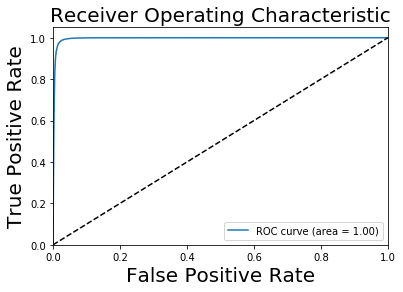

In [29]:
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(Y_Validation[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr[2], tpr[2], label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=20)
plt.ylabel('True Positive Rate',fontsize=20)
plt.title('Receiver Operating Characteristic',fontsize=20)
plt.legend(loc="lower right")
plt.show()

### Confusion Matrix

In [30]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=30,fontsize=15)
    plt.yticks(tick_marks, classes,fontsize=15)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",fontsize=15)

    plt.ylabel('TRUE LABEL',fontsize=20)
    plt.xlabel('PREDICTED LABEL',fontsize=20)
    #fig.set_size_inches(14, 10)
    plt.tight_layout()

In [31]:
from sklearn.metrics import confusion_matrix

#Y_train_predict = Best_Model.predict_proba(pcTrain)
Y_val_predict = Best_Model.predict_proba(pcValidation)
Y_val_single_col = np.where(Y_Validation==1)[1]
Y_val_mo = pd.get_dummies(Y_val_single_col[:])
Y_val_predict_mo = Y_val_predict.round()
cnf_matrix = confusion_matrix(Y_val_mo.values.argmax(axis=1), Y_val_predict_mo.argmax(axis=1))

Normalized confusion matrix
[[3.57142857e-03 3.82142857e-01 6.14285714e-01]
 [2.69212622e-03 9.68582609e-01 2.87252644e-02]
 [7.69158321e-04 7.25206417e-03 9.91978778e-01]]


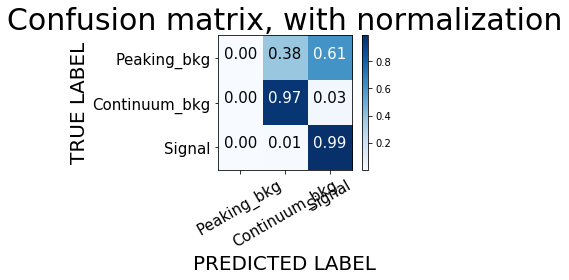

In [32]:
import itertools

plot_confusion_matrix(cnf_matrix, classes=['Peaking_bkg', 'Continuum_bkg', 'Signal'],
                       title='Confusion matrix, with normalization')

### Store the Weights

In [33]:
Best_Model.save("Best_Model.h5")

In [34]:
Best_Model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_2 (Dropout)          (None, 83)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 50)                4200      
_________________________________________________________________
dense_5 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 153       
Total params: 6,903
Trainable params: 6,903
Non-trainable params: 0
_________________________________________________________________


### Try Loading the model

In [35]:
!ls

Analysis.ipynb	      environment.yml	    Pecularity_in_the_Signal_File.ipynb
Best_Model.h5	      Keras_Analysis.ipynb  README.md
Data_Challenge.ipynb  PCA.pkl		    Scaler.pkl


In [36]:
from keras.models import load_model

Loaded_Model = load_model('Best_Model.h5')
Loaded_Model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_2 (Dropout)          (None, 83)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 50)                4200      
_________________________________________________________________
dense_5 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 153       
Total params: 6,903
Trainable params: 6,903
Non-trainable params: 0
_________________________________________________________________


In [37]:
Loaded_Model.evaluate(pcTest, Y_Test, verbose=1)

66679/66679 [==============================] - 2s 23us/step


[0.009900255424606128, 0.9823182711198428]